### Part 1 - COVID Dataset: Implementing Fully Connected Deep Neural Networks

In [1]:
import sys
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.decomposition import PCA
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

#### Feature Description
##### • Day: Date in January 2021 ranging from Jan 2 to Jan 31.
##### • State ID: Arbitrary ID number for each state, based on alphabetical order. Note there are 51 states since the District of Columbia is also included.
##### • State: Name of the US State.
##### • Lat: Latitude for the geographic centre of the state.
##### • Long : Longitude for the geographic centre of the state.
##### • Active: Number of active, tracked COVID-19 cases that day in that state.
##### • Incident Rate: cases per 100,000 persons
##### • Total Test Results: Total number of people who have been tested
##### • Case Fatality Ratio(%): Number recorded deaths / Number cases.
##### • Testing Rate: Total test results per 100,000 persons
##### • Resident Population 2021 Census: see original data source
##### • Population Density 2021 Census: see original data source
##### • Density Rank 2021 Census: see original data source
##### • SexRatio: see original data source

### 2.1 [CM1] Data Preprocessing

The data preprocessing steps have been similar to the steps we have used in our earlier assignment, and they are as follows:
1. Checking for Missing values in Columns.
2. Checking for duplicate records and dropping it if any.
3. Removing features that are highly dependent upon each other. In Covid Dataset we have [State ID], so we do not need [State, Long, Lat] and dropping these features.
4. Type Casting the [Resident Population 2020 Census] and [Population Density 2020 Census] data into float data type.
5. Adding the relative difference of specific quanititative attributes with respect to the state.
6. Checking for outliers - Data point that differs significantly from other observations.By plotting Histograms, we look at data distribution for a variable and find values that fall outside the distribution.
7. Performing Z Score Regularization - score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. If the Z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier. 
8. Outliers Removal: - Removing those rows that have [Incident_Rate] greater than 2.5 Z-Score value or lesser than -2.5 Z-Score value Removing those rows that have [Case_Fatality_Ratio] greater than 3 Z-Score value or lesser than -3 Z-Score value.
9. Applying PCA on the covid features and creating a hybrid dataset with a combination of original features along with first five PCA components.

In [3]:
df = pd.read_csv('dkmacovid_train.csv')

In [4]:
df.sample(10)

,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered
989,23,26,Missouri,38.4561,-92.2884,452974,7490.890321,4031558,1.473416,65688.06999,"6,154,913",89.5,30,96,True,True,False
501,12,46,Vermont,44.0459,-72.7107,2863,1481.917149,767325,1.708662,122970.91780,"643,077",69.8,33,97,True,True,True
1229,28,36,Ohio,40.3888,-82.7649,108230,7560.171442,8921429,1.245423,76322.63391,"11,799,448",288.8,12,96,True,True,True
668,16,27,Montana,46.9219,-110.4544,5048,8332.506844,874943,1.221703,81863.86696,"1,084,225",7.4,50,101,True,True,True
140,5,3,Arizona,33.7298,-111.4312,477855,7796.346526,5324030,1.641837,40580.39350,"7,151,502",62.9,35,99,True,True,True
66,3,23,Michigan,43.3266,-84.5361,161204,5388.291832,8122575,2.472678,81332.64550,"10,077,331",178,20,97,False,False,False
1342,31,9,District of Columbia,38.8974,-77.0268,10149,5224.520332,1100466,2.476134,155928.80760,"689,545","11,280.00",1,96,True,True,True
428,11,17,Kansas,38.5266,-96.7265,240502,8534.816364,1066516,1.306275,36608.34363,"2,937,880",35.9,43,99,True,True,True
813,19,34,North Carolina,35.6301,-79.8064,96785,6526.425608,8186392,1.189048,78054.21848,"10,439,388",214.7,17,95,True,True,True
1281,29,42,South Dakota,44.2998,-99.4388,3060,12203.007030,400824,1.637719,45308.30523,"886,667",11.7,48,102,True,True,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Day                              1380 non-null   int64  
 1   State ID                         1380 non-null   int64  
 2   State                            1380 non-null   object 
 3   Lat                              1380 non-null   float64
 4   Long_                            1380 non-null   float64
 5   Active                           1380 non-null   int64  
 6   Incident_Rate                    1380 non-null   float64
 7   Total_Test_Results               1380 non-null   int64  
 8   Case_Fatality_Ratio              1380 non-null   float64
 9   Testing_Rate                     1380 non-null   float64
 10  Resident Population 2020 Census  1380 non-null   object 
 11  Population Density 2020 Census   1380 non-null   object 
 12  Density Rank 2020 Ce

In [6]:
#checking for null values
df.isnull().sum()

Day                                0
State ID                           0
State                              0
Lat                                0
Long_                              0
Active                             0
Incident_Rate                      0
Total_Test_Results                 0
Case_Fatality_Ratio                0
Testing_Rate                       0
Resident Population 2020 Census    0
Population Density 2020 Census     0
Density Rank 2020 Census           0
SexRatio                           0
Confirmed                          0
Deaths                             0
Recovered                          0
dtype: int64

In [7]:
#Checking for duplicate rows
duplicated = df.duplicated().sum()
if duplicated:
    print('Duplicates in the Covid dataset are: {}'.format(duplicated))
else:
    print('Dataset does not contain any duplicate values.')

Dataset does not contain any duplicate values.


In [8]:
#Provides the previous and current data record of a list with respect to index
def neighbor(iterable):
    iterator = iter(iterable)
    previous_item = None
    current_item = next(iterator)
    for next_item in iterator:
        yield(previous_item, current_item)
        previous_item = current_item
        current_item = next_item
    yield(previous_item, current_item)

#Utilities used in Pre-processing of the data
def ReativeFeature(dataFrame, feature):
    new_feature = "Relative_" + feature 
    dataFrame[new_feature] = np.nan
    states = dataFrame.State.unique()
    for state in states:
        df_state = dataFrame[dataFrame['State'] == state]
        feature_state = df_state[feature].tolist()
        diff_feature =[]
        for previous, current in neighbor(feature_state):
            if(previous== None):
                diff_feature.append(1)
            else:
                diff_feature.append((current - previous))
        dataFrame.loc[(dataFrame['State'] == state), new_feature] = diff_feature
    return dataFrame

# Getting the relative difference values for specific quantitative attributes with respect to the state
df = ReativeFeature(df, 'Active')
df = ReativeFeature(df, 'Case_Fatality_Ratio')
df = ReativeFeature(df, 'Incident_Rate')
df = ReativeFeature(df, 'Total_Test_Results')
df = ReativeFeature(df, 'Testing_Rate')

df

,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,...,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,2,1,Alabama,32.3182,-86.9023,162449,7535.061394,1891468,1.318688,38576.31315,...,29,94,True,False,False,1.0,1.000000,1.000000,1.0,1.00000
1,2,2,Alaska,61.3707,-152.4044,40421,6534.252848,1290349,0.449781,176386.82510,...,52,109,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
2,2,3,Arizona,33.7298,-111.4312,452222,7407.212013,5218721,1.680608,39916.14181,...,35,99,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
3,2,4,Arkansas,34.9697,-92.3731,24012,7669.219075,2079788,1.611203,68917.26567,...,36,96,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
4,2,5,California,36.1162,-119.6816,2362015,6045.109130,33391442,1.111215,84509.14544,...,13,99,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,31,46,Vermont,44.0459,-72.7107,3537,1917.501751,897351,1.454242,143808.78510,...,33,97,True,True,True,-26.0,-0.008019,21.474738,7674.0,1229.82940
1376,31,47,Virginia,37.7693,-78.1700,457993,5913.864172,5234155,1.280560,61322.04732,...,16,97,True,True,True,1413.0,-0.003536,29.968887,23920.0,280.24072
1377,31,49,West Virginia,38.4912,-80.9545,21195,6751.734093,1945579,1.672713,108561.35130,...,31,98,True,True,True,-612.0,-0.001709,36.883135,8719.0,486.51150
1378,31,50,Wisconsin,44.2685,-89.6165,68537,10169.973590,6177575,1.086567,106099.52810,...,27,99,True,True,True,-285.0,-0.001425,19.630970,22737.0,390.50680


In [9]:
#Removing features that are highly dependant upon each other. For example, we have state ID,
#thus we do not need state names, latitutde and longitude measures.

covid = df.copy(deep=True)
covid = covid.drop('Lat', axis=1)
covid = covid.drop('Long_', axis=1)
covid = covid.drop('State', axis=1)

In [10]:
covid

,Day,State ID,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Confirmed,Deaths,Recovered,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,2,1,162449,7535.061394,1891468,1.318688,38576.31315,"5,024,279",99.2,29,94,True,False,False,1.0,1.000000,1.000000,1.0,1.00000
1,2,2,40421,6534.252848,1290349,0.449781,176386.82510,"733,391",1.3,52,109,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
2,2,3,452222,7407.212013,5218721,1.680608,39916.14181,"7,151,502",62.9,35,99,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
3,2,4,24012,7669.219075,2079788,1.611203,68917.26567,"3,011,524",57.9,36,96,True,True,True,1.0,1.000000,1.000000,1.0,1.00000
4,2,5,2362015,6045.109130,33391442,1.111215,84509.14544,"39,538,223",253.7,13,99,True,True,False,1.0,1.000000,1.000000,1.0,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,31,46,3537,1917.501751,897351,1.454242,143808.78510,"643,077",69.8,33,97,True,True,True,-26.0,-0.008019,21.474738,7674.0,1229.82940
1376,31,47,457993,5913.864172,5234155,1.280560,61322.04732,"8,631,393",218.6,16,97,True,True,True,1413.0,-0.003536,29.968887,23920.0,280.24072
1377,31,49,21195,6751.734093,1945579,1.672713,108561.35130,"1,793,716",74.6,31,98,True,True,True,-612.0,-0.001709,36.883135,8719.0,486.51150
1378,31,50,68537,10169.973590,6177575,1.086567,106099.52810,"5,893,718",108.8,27,99,True,True,True,-285.0,-0.001425,19.630970,22737.0,390.50680


In [11]:
#Type-casting the population and population density data into float data type
covid[['Resident Population 2020 Census', 'Population Density 2020 Census']] = covid[['Resident Population 2020 Census', 
                                                                                      'Population Density 2020 Census']].replace({",":""},
                                                                                       regex=True).apply(pd.to_numeric,1)
covid.describe()

,Day,State ID,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
count,1380.000000,1380.000000,1.380000e+03,1380.000000,1.380000e+03,1380.000000,1380.000000,1.380000e+03,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,16.500000,25.239130,2.610390e+05,7203.192905,5.271097e+06,1.631757,91763.237514,5.906191e+06,454.834783,27.173913,97.760870,2125.057971,0.032306,51.506535,34294.601449,555.077024
std,8.658579,14.513405,4.914059e+05,2305.025102,6.991478e+06,0.656702,40858.185997,6.858898e+06,1638.774933,15.378197,3.219219,7209.638027,0.180632,39.730615,59443.432853,679.818836
min,2.000000,1.000000,9.550000e+02,1232.233261,3.739460e+05,0.439598,30524.071590,5.768510e+05,1.300000,1.000000,94.000000,-78446.000000,-0.401078,-39.851523,-175618.000000,-4925.774500
25%,9.000000,12.000000,2.731600e+04,6042.134459,1.310515e+06,1.246993,67457.197525,1.455271e+06,44.100000,13.000000,95.000000,0.000000,-0.005693,27.924939,5235.500000,210.801003
50%,16.500000,25.500000,1.005915e+05,7453.675955,2.919566e+06,1.499993,85438.613770,4.098304e+06,103.500000,28.500000,97.000000,621.000000,-0.000398,47.003211,13717.500000,457.821910
75%,24.000000,37.000000,2.592418e+05,8621.924085,6.093790e+06,1.817013,104509.453475,7.029917e+06,253.700000,41.000000,99.000000,3120.750000,0.005113,68.112895,39626.500000,740.012500
max,31.000000,51.000000,3.283336e+06,12811.162350,4.227902e+07,3.928767,235733.711200,3.953822e+07,11280.000000,52.000000,109.000000,61334.000000,1.000000,695.695544,473076.000000,11903.445700


In [12]:
#Handling outliers
#Removing those rows that have incident_rate greater than 2.5 Z-Score value or lesser than -2.5 Z-Score value
covid['zscore_incident_rate'] = (covid.Incident_Rate - covid.Incident_Rate.mean())/covid.Incident_Rate.std()
covid_no_outliers = covid[(covid.zscore_incident_rate>-2.5) & (covid.zscore_incident_rate<2.5)]
#Removing those rows that have Case_Fatality_Ratio greater than 3 Z-Score value or lesser than -3 Z-Score value
covid_no_outliers['zscore_Case_Fatality_Ratio'] = (covid_no_outliers.Case_Fatality_Ratio - covid_no_outliers.Case_Fatality_Ratio.mean())/covid_no_outliers.Case_Fatality_Ratio.std()
covid_no_outliers = covid_no_outliers[(covid_no_outliers.zscore_Case_Fatality_Ratio>-3) & (covid_no_outliers.zscore_Case_Fatality_Ratio<3)]

/Users/snigdhakakkar/opt/anaconda2/envs/tf/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [13]:
covid_no_outliers

,Day,State ID,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,...,Confirmed,Deaths,Recovered,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate,zscore_incident_rate,zscore_Case_Fatality_Ratio
0,2,1,162449,7535.061394,1891468,1.318688,38576.31315,5024279.0,99.2,29,...,True,False,False,1.0,1.000000,1.000000,1.0,1.00000,0.143976,-0.473486
1,2,2,40421,6534.252848,1290349,0.449781,176386.82510,733391.0,1.3,52,...,True,True,False,1.0,1.000000,1.000000,1.0,1.00000,-0.290209,-1.792644
2,2,3,452222,7407.212013,5218721,1.680608,39916.14181,7151502.0,62.9,35,...,True,True,True,1.0,1.000000,1.000000,1.0,1.00000,0.088511,0.075974
3,2,4,24012,7669.219075,2079788,1.611203,68917.26567,3011524.0,57.9,36,...,True,True,True,1.0,1.000000,1.000000,1.0,1.00000,0.202178,-0.029397
4,2,5,2362015,6045.109130,33391442,1.111215,84509.14544,39538223.0,253.7,13,...,True,True,False,1.0,1.000000,1.000000,1.0,1.00000,-0.502417,-0.788468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,31,46,3537,1917.501751,897351,1.454242,143808.78510,643077.0,69.8,33,...,True,True,True,-26.0,-0.008019,21.474738,7674.0,1229.82940,-2.293117,-0.267692
1376,31,47,457993,5913.864172,5234155,1.280560,61322.04732,8631393.0,218.6,16,...,True,True,True,1413.0,-0.003536,29.968887,23920.0,280.24072,-0.559356,-0.531371
1377,31,49,21195,6751.734093,1945579,1.672713,108561.35130,1793716.0,74.6,31,...,True,True,True,-612.0,-0.001709,36.883135,8719.0,486.51150,-0.195859,0.063988
1378,31,50,68537,10169.973590,6177575,1.086567,106099.52810,5893718.0,108.8,27,...,True,True,True,-285.0,-0.001425,19.630970,22737.0,390.50680,1.287093,-0.825888


In [14]:
#Extracting covid features and separating labels
covid_features = covid_no_outliers[covid_no_outliers.columns.difference(['Confirmed', 'Deaths', 'Recovered'])]
covid_features.head()

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results,zscore_Case_Fatality_Ratio,zscore_incident_rate
0,162449,1.318688,2,29,7535.061394,99.2,1.0,1.0,1.0,1.0,1.0,5024279.0,94,1,38576.31315,1891468,-0.473486,0.143976
1,40421,0.449781,2,52,6534.252848,1.3,1.0,1.0,1.0,1.0,1.0,733391.0,109,2,176386.82510,1290349,-1.792644,-0.290209
2,452222,1.680608,2,35,7407.212013,62.9,1.0,1.0,1.0,1.0,1.0,7151502.0,99,3,39916.14181,5218721,0.075974,0.088511
3,24012,1.611203,2,36,7669.219075,57.9,1.0,1.0,1.0,1.0,1.0,3011524.0,96,4,68917.26567,2079788,-0.029397,0.202178
4,2362015,1.111215,2,13,6045.109130,253.7,1.0,1.0,1.0,1.0,1.0,39538223.0,99,5,84509.14544,33391442,-0.788468,-0.502417


In [15]:
#Droppping the Z-Score columns created earlier for outlier removal
covid_features = covid_features.drop('zscore_incident_rate', axis=1)
covid_features = covid_features.drop('zscore_Case_Fatality_Ratio', axis=1)

In [16]:
#Z-Score regularization
scaler = preprocessing.StandardScaler()
scaled_covid=covid_features.copy()
scaled_covid=pd.DataFrame(scaler.fit_transform(scaled_covid), columns=scaled_covid.columns)
scaled_covid

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,-0.195777,-0.464218,-1.707601,0.106749,0.121637,-0.214196,-0.288806,5.500393,-1.270941,-0.811293,-0.575471,-0.122058,-1.176911,-1.655724,-1.287634,-0.478689
1,-0.443336,-1.857465,-1.707601,1.607534,-0.319892,-0.273510,-0.288806,5.500393,-1.270941,-0.811293,-0.575471,-0.750291,3.470232,-1.586831,2.070483,-0.565846
2,0.392085,0.116101,-1.707601,0.498258,0.065233,-0.236189,-0.288806,5.500393,-1.270941,-0.811293,-0.575471,0.189390,0.372137,-1.517938,-1.254986,0.003737
3,-0.476625,0.004813,-1.707601,0.563510,0.180824,-0.239218,-0.288806,5.500393,-1.270941,-0.811293,-0.575471,-0.416748,-0.557292,-1.449044,-0.548297,-0.451384
4,4.266484,-0.796891,-1.707601,-0.937275,-0.535689,-0.120591,-0.288806,5.500393,-1.270941,-0.811293,-0.575471,4.931160,0.372137,-1.380151,-0.168360,4.088558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,-0.518162,-0.246866,1.663992,0.367755,-2.356675,-0.232009,-0.292541,-0.220979,-0.757408,0.999591,-0.445115,-0.763514,-0.247482,1.444475,1.276633,-0.622828
1353,0.403793,-0.525355,1.663992,-0.741521,-0.593591,-0.141856,-0.093508,-0.195535,-0.544363,-0.399786,-0.169114,0.406063,-0.247482,1.513369,-0.733374,0.005975
1354,-0.482340,0.103442,1.663992,0.237252,-0.223945,-0.229101,-0.373592,-0.185167,-0.370944,-0.095812,-0.427362,-0.595048,0.062327,1.651155,0.417736,-0.470843
1355,-0.386297,-0.836412,1.663992,-0.023754,1.284087,-0.208380,-0.328364,-0.183553,-0.803652,-0.237290,-0.189212,0.005237,0.372137,1.720049,0.357747,0.142763


In [17]:
scaled_covid.dtypes

Active                             float64
Case_Fatality_Ratio                float64
Day                                float64
Density Rank 2020 Census           float64
Incident_Rate                      float64
Population Density 2020 Census     float64
Relative_Active                    float64
Relative_Case_Fatality_Ratio       float64
Relative_Incident_Rate             float64
Relative_Testing_Rate              float64
Relative_Total_Test_Results        float64
Resident Population 2020 Census    float64
SexRatio                           float64
State ID                           float64
Testing_Rate                       float64
Total_Test_Results                 float64
dtype: object

In [18]:
#PCA Implementation
def implement_PCA(components, data, svd_solver='auto'):
    pca = PCA(n_components = components, svd_solver=svd_solver)
    Principal_Components = pca.fit_transform(data)
    df_pca = pd.DataFrame(data = Principal_Components)
    return(df_pca, pca)

def PCA_ScreePlot(pca):
    pc_value = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(15,8)) 
    plt.plot(pc_value, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.grid()
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of variance explained')
    plt.locator_params(axis="y", nbins=25)
    plt.show()
    
#Applying PCA with n_components = 10
pca_implement = implement_PCA(components = 10, data=scaled_covid)
pca_features_covid = pca_implement[0]
pca_covid_data = pca_implement[1]

In [19]:
#Scaling the original features dataframe while excluding Day column from scaling
scaler = preprocessing.StandardScaler()
scaled_features=covid_features.copy(deep = True)
scaled_features[['Active','Case_Fatality_Ratio','Incident_Rate', 
                 'Density Rank 2020 Census','Population Density 2020 Census',
                 'Relative_Active', 'Relative_Case_Fatality_Ratio','Total_Test_Results',
                 'Relative_Incident_Rate','Relative_Testing_Rate', 
                 'Testing_Rate', 'Resident Population 2020 Census', 
                 'Relative_Total_Test_Results', 'State ID','SexRatio']]=pd.DataFrame(scaler.fit_transform(scaled_features[['Active','Case_Fatality_Ratio',                              
                                                    'Incident_Rate', 'Density Rank 2020 Census',                           
                                                    'Population Density 2020 Census',
                                                    'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                                    'Total_Test_Results','Relative_Incident_Rate', 
                                                    'Relative_Testing_Rate', 
                                                    'Testing_Rate', 'Resident Population 2020 Census', 
                                                    'Relative_Total_Test_Results','State ID','SexRatio']]))
scaled_features.shape

(1357, 16)

In [20]:
#Making the hybrid dataset by using non-scaled covid_train dataset along with its first 5 PCA components.
x = pca_features_covid[0].tolist()
scaled_features.loc[:, 'PCA1'] = x
x = pca_features_covid[1].tolist()
scaled_features.loc[:, 'PCA2'] = x
x = pca_features_covid[2].tolist()
scaled_features.loc[:, 'PCA3'] = x
x = pca_features_covid[3].tolist()
scaled_features.loc[:, 'PCA4'] = x
x = pca_features_covid[4].tolist()
scaled_features.loc[:, 'PCA5'] = x

scaled_features.dropna(subset =['Active', 'Incident_Rate'], how ='all')

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,...,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results,PCA1,PCA2,PCA3,PCA4,PCA5
0,-0.195777,-0.464218,2,0.106749,0.121637,-0.214196,-0.288806,5.500393,-1.270941,-0.811293,...,-0.122058,-1.176911,-1.655724,-1.287634,-0.478689,-1.009131,-0.371646,-4.721033,-0.782071,2.181960
1,-0.443336,-1.857465,2,1.607534,-0.319892,-0.273510,-0.288806,5.500393,-1.270941,-0.811293,...,-0.750291,3.470232,-1.586831,2.070483,-0.565846,-2.799929,-2.220530,-2.018296,-2.923081,5.405076
2,0.392085,0.116101,2,0.498258,0.065233,-0.236189,-0.288806,5.500393,-1.270941,-0.811293,...,0.189390,0.372137,-1.517938,-1.254986,0.003737,-0.768488,-1.114855,-4.403581,-1.326505,2.643840
3,-0.476625,0.004813,2,0.563510,0.180824,-0.239218,-0.288806,5.500393,-1.270941,-0.811293,...,-0.416748,-0.557292,-1.449044,-0.548297,-0.451384,-1.392379,-0.300380,-4.131632,-1.125263,2.605345
4,4.266484,-0.796891,2,-0.937275,-0.535689,-0.120591,-0.288806,5.500393,-1.270941,-0.811293,...,4.931160,0.372137,-1.380151,-0.168360,4.088558,4.793289,-2.934677,-5.064497,-3.108906,2.658226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,-0.518162,-0.246866,31,0.367755,-2.356675,-0.232009,-0.292541,-0.220979,-0.757408,0.999591,...,-0.763514,-0.247482,1.444475,1.276633,-0.622828,1.090451,1.608429,0.251093,-1.046496,-1.238491
1353,0.403793,-0.525355,31,-0.741521,-0.593591,-0.141856,-0.093508,-0.195535,-0.544363,-0.399786,...,0.406063,-0.247482,1.513369,-0.733374,0.005975,2.199681,2.588090,1.865780,-1.669327,-0.460576
1354,-0.482340,0.103442,31,0.237252,-0.223945,-0.229101,-0.373592,-0.185167,-0.370944,-0.095812,...,-0.595048,0.062327,1.651155,0.417736,-0.470843,0.303293,0.859866,-0.506247,-1.727328,-1.809331
1355,-0.386297,-0.836412,31,-0.023754,1.284087,-0.208380,-0.328364,-0.183553,-0.803652,-0.237290,...,0.005237,0.372137,1.720049,0.357747,0.142763,-0.659672,-0.345273,0.873175,-1.434800,-0.905857


In [21]:
#Making the hybrid dataset by using scaled covid_train dataset along with its first 5 PCA components.
features_hybrid = scaled_covid.copy(deep=True)
x = pca_features_covid[0].tolist()
features_hybrid.loc[:, 'PCA1'] = x
x = pca_features_covid[1].tolist()
features_hybrid.loc[:, 'PCA2'] = x
x = pca_features_covid[2].tolist()
features_hybrid.loc[:, 'PCA3'] = x
x = pca_features_covid[3].tolist()
features_hybrid.loc[:, 'PCA4'] = x
x = pca_features_covid[4].tolist()
features_hybrid.loc[:, 'PCA5'] = x

features_hybrid.head()

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,...,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results,PCA1,PCA2,PCA3,PCA4,PCA5
0,-0.195777,-0.464218,-1.707601,0.106749,0.121637,-0.214196,-0.288806,5.500393,-1.270941,-0.811293,...,-0.122058,-1.176911,-1.655724,-1.287634,-0.478689,-1.009131,-0.371646,-4.721033,-0.782071,2.181960
1,-0.443336,-1.857465,-1.707601,1.607534,-0.319892,-0.273510,-0.288806,5.500393,-1.270941,-0.811293,...,-0.750291,3.470232,-1.586831,2.070483,-0.565846,-2.799929,-2.220530,-2.018296,-2.923081,5.405076
2,0.392085,0.116101,-1.707601,0.498258,0.065233,-0.236189,-0.288806,5.500393,-1.270941,-0.811293,...,0.189390,0.372137,-1.517938,-1.254986,0.003737,-0.768488,-1.114855,-4.403581,-1.326505,2.643840
3,-0.476625,0.004813,-1.707601,0.563510,0.180824,-0.239218,-0.288806,5.500393,-1.270941,-0.811293,...,-0.416748,-0.557292,-1.449044,-0.548297,-0.451384,-1.392379,-0.300380,-4.131632,-1.125263,2.605345
4,4.266484,-0.796891,-1.707601,-0.937275,-0.535689,-0.120591,-0.288806,5.500393,-1.270941,-0.811293,...,4.931160,0.372137,-1.380151,-0.168360,4.088558,4.793289,-2.934677,-5.064497,-3.108906,2.658226


### 2.2 Deep Neural Networks

#### Network design: We have chosen to use our data as is, with three networks making binary classification decisions for each datapoint

### CM2: Default network

In [285]:
X_train = features_hybrid.copy()
y_train = covid_no_outliers.copy()
y_train = y_train[y_train.columns.difference(['Day', 'State ID', 'Active', 'Incident_Rate', 'Total_Test_Results',
                                             'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census',
                                              'Population Density 2020 Census', 'Density Rank 2020 Census', 
                                              'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                              'Relative_Incident_Rate', 'Relative_Total_Test_Results',
                                              'Relative_Testing_Rate', 'zscore_incident_rate',
                                              'zscore_Case_Fatality_Ratio','SexRatio'])]

In [286]:
#Checking for X_train shape
X_train.shape

(1357, 21)

In [287]:
#Checking for y_train shape
y_train.shape

(1357, 3)

In [288]:
#Split the Train dataset into train and test data (taking 15% for testing):
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.15, random_state = 0, 
                                                    shuffle=True)

In [289]:
#Split the Train dataset into train and validation data (taking 10% for testing):
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train1, y_train1, test_size=0.10, random_state=0, shuffle=True)

In [290]:
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train2.shape))
print('y_train:\t{}'.format(y_train2.shape))
print('X_validation:\t{}'.format(X_val2.shape))
print('y_validation:\t{}'.format(y_val2.shape))
print('X_test:\t{}'.format(X_test1.shape))
print('y_test:\t{}'.format(y_test1.shape))

X_train:	(1037, 21)
y_train:	(1037, 3)
X_validation:	(116, 21)
y_validation:	(116, 3)
X_test:	(204, 21)
y_test:	(204, 3)


In [291]:
#Separating y-train, y-test and y-val for the three labels: Recovered, Deaths, Confirmed
y_train_Recovered = y_train2.copy()
y_train_Recovered = y_train2[y_train2.columns.difference(['Confirmed', 'Deaths'])]
y_train_Confirmed = y_train2.copy()
y_train_Confirmed = y_train2[y_train2.columns.difference(['Recovered', 'Deaths'])]
y_train_Deaths = y_train2.copy()
y_train_Deaths = y_train2[y_train2.columns.difference(['Recovered', 'Confirmed'])]

y_val_Recovered = y_val2.copy()
y_val_Recovered = y_val2[y_val2.columns.difference(['Confirmed', 'Deaths'])]
y_val_Confirmed = y_val2.copy()
y_val_Confirmed = y_val2[y_val2.columns.difference(['Recovered', 'Deaths'])]
y_val_Deaths = y_val2.copy()
y_val_Deaths = y_val2[y_val2.columns.difference(['Recovered', 'Confirmed'])]

y_test_Recovered = y_test1.copy()
y_test_Recovered = y_test1[y_test1.columns.difference(['Confirmed', 'Deaths'])]
y_test_Confirmed = y_test1.copy()
y_test_Confirmed = y_test1[y_test1.columns.difference(['Recovered', 'Deaths'])]
y_test_Deaths = y_test1.copy()
y_test_Deaths = y_test1[y_test1.columns.difference(['Recovered', 'Confirmed'])]

In [292]:
y_train_Recovered = y_train_Recovered.astype(int)
y_train_Confirmed = y_train_Confirmed.astype(int)
y_train_Deaths = y_train_Deaths.astype(int)

y_val_Recovered = y_val_Recovered.astype(int)
y_val_Confirmed = y_val_Confirmed.astype(int)
y_val_Deaths = y_val_Deaths.astype(int)

y_test_Recovered = y_test_Recovered.astype(int)
y_test_Confirmed = y_test_Confirmed.astype(int)
y_test_Deaths = y_test_Deaths.astype(int)

In [166]:
#Transforming the y_train, y_validation and y_test in categorical form
from tensorflow.keras.utils import to_categorical

nClasses = 2
y_train_Recovered = to_categorical(y_train_Recovered,nClasses)
y_train_Confirmed = to_categorical(y_train_Confirmed,nClasses)
y_train_Deaths= to_categorical(y_train_Deaths,nClasses)

y_val_Recovered = to_categorical(y_val_Recovered,nClasses)
y_val_Confirmed = to_categorical(y_val_Confirmed,nClasses)
y_val_Deaths= to_categorical(y_val_Deaths,nClasses)

y_test_Recovered = to_categorical(y_test_Recovered,nClasses)
y_test_Confirmed = to_categorical(y_test_Confirmed,nClasses)
y_test_Deaths= to_categorical(y_test_Deaths,nClasses)

#### Building the default Deep Neural Network Model for Recovered labels

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 20)                440       
_________________________________________________________________
dense_96 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  8.689620018005371 seconds
Train accuracy for default DNN model on Recovered labels: 0.988,Validation accuracy for default DNN model on Recovered labels: 0.991
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


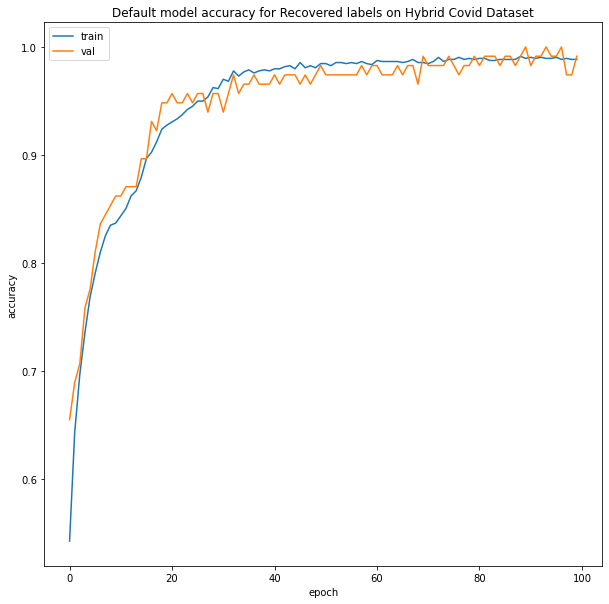

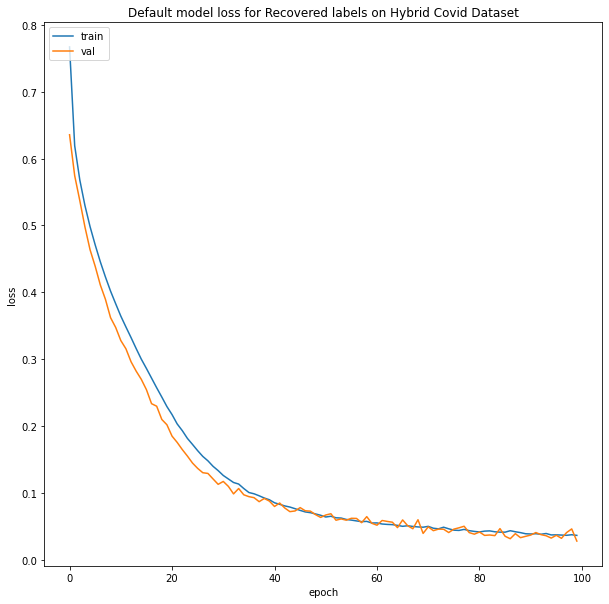

In [216]:
import time #For calculating the time taken to train the model

input_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

default_model_Recovered = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Recovered.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Recovered.summary())

# fit the network
start = time.time()
history = default_model_Recovered.fit(X_train2,y_train_Recovered, epochs = 100,
                            validation_data=(X_val2,y_val_Recovered), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Recovered.evaluate(X_train2,y_train_Recovered, verbose=0)
_, validation_acc = default_model_Recovered.evaluate(X_val2,y_val_Recovered, verbose=0)
print('Train accuracy for default DNN model on Recovered labels: %.3f,Validation accuracy for default DNN model on Recovered labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Recovered labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Recovered.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Recovered labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Recovered.png")

In [217]:
#Evaluating the default DNN model on the test dataset for Recovered class labels
default_model_Recovered.evaluate(X_test1, y_test_Recovered, batch_size=50)

204/204 [==============================] - 0s 143us/sample - loss: 0.1257 - accuracy: 0.9657


[0.125667399279408, 0.96568626]

#### Building the default Deep Neural Network Model for Deaths labels

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 20)                440       
_________________________________________________________________
dense_102 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_103 (Dense)            (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  8.648208141326904 seconds
Train accuracy for default DNN model on Deaths labels: 0.949,Validation accuracy for default DNN model on Deaths labels: 0.931
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


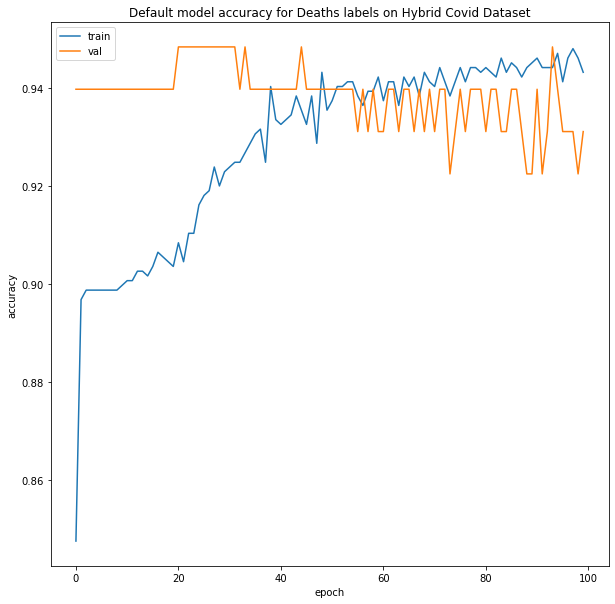

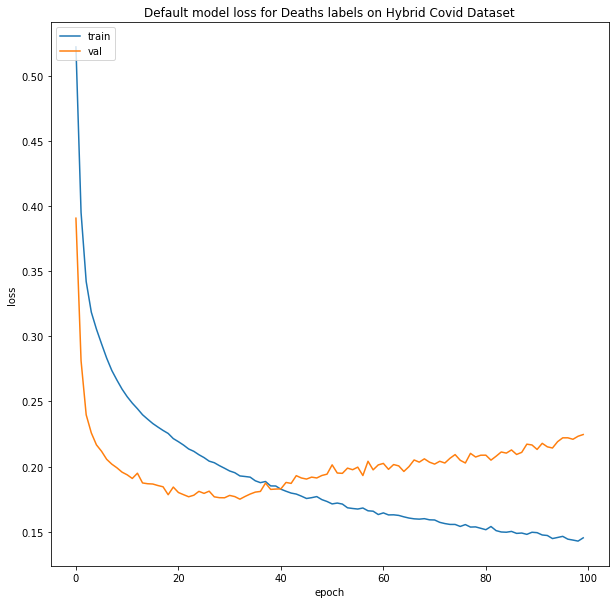

In [219]:
input_shape = X_train2.shape[1]
out_shape = y_train_Deaths.shape[1]

default_model_Deaths = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Deaths.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Deaths.summary())

# fit the network
start = time.time()
history = default_model_Deaths.fit(X_train2,y_train_Deaths, epochs = 100,
                            validation_data=(X_val2,y_val_Deaths), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Deaths.evaluate(X_train2,y_train_Deaths, verbose=0)
_, validation_acc = default_model_Deaths.evaluate(X_val2,y_val_Deaths, verbose=0)
print('Train accuracy for default DNN model on Deaths labels: %.3f,Validation accuracy for default DNN model on Deaths labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Deaths labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Deaths.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Deaths labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Deaths.png")

In [220]:
#Evaluating the default DNN model on the test dataset for Deaths class labels
default_model_Deaths.evaluate(X_test1, y_test_Deaths, batch_size=50)

204/204 [==============================] - 0s 121us/sample - loss: 0.1814 - accuracy: 0.9363


[0.18138509579733306, 0.9362745]

#### Building the default Deep Neural Network Model for Confirmed labels

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 20)                440       
_________________________________________________________________
dense_105 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_106 (Dense)            (None, 2)                 42        
Total params: 902
Trainable params: 902
Non-trainable params: 0
_________________________________________________________________
None
Total time:  9.373209714889526 seconds
Train accuracy for default DNN model on Confirmed labels: 0.996,Validation accuracy for default DNN model on Confirmed labels: 0.991
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


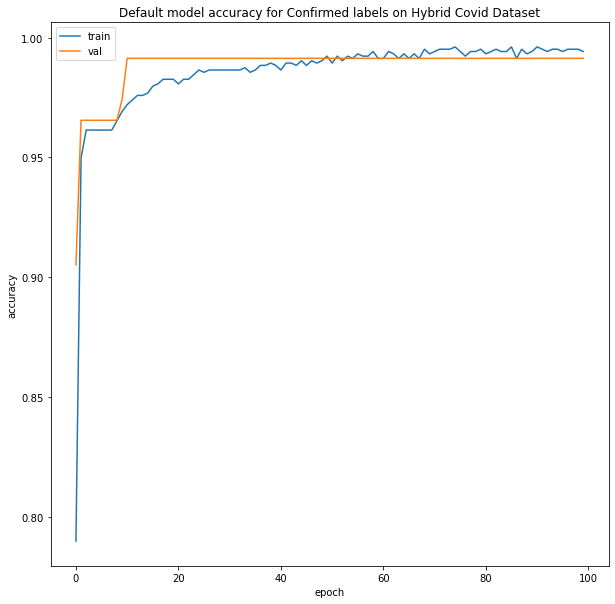

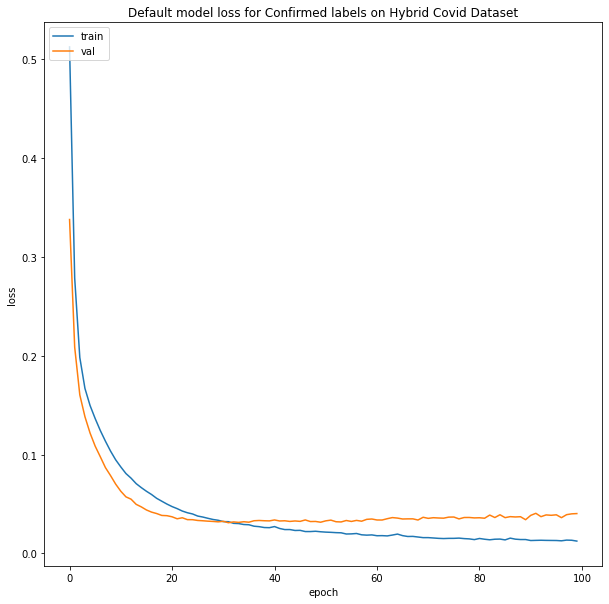

In [221]:
input_shape = X_train2.shape[1]
out_shape = y_train_Confirmed.shape[1]

default_model_Confirmed = Sequential([
    layers.Dense(20, activation='relu', input_shape=(input_shape,) ),
    layers.Dense(20, activation='relu'),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

default_model_Confirmed.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(default_model_Confirmed.summary())

# fit the network
start = time.time()
history = default_model_Confirmed.fit(X_train2,y_train_Confirmed, epochs = 100,
                            validation_data=(X_val2,y_val_Confirmed), 
                            verbose=0, batch_size=50)
print("Total time: ", time.time() - start, "seconds")

#Evaluating the model on training and validation dataset
_, train_acc = default_model_Confirmed.evaluate(X_train2,y_train_Confirmed, verbose=0)
_, validation_acc = default_model_Confirmed.evaluate(X_val2,y_val_Confirmed, verbose=0)
print('Train accuracy for default DNN model on Confirmed labels: %.3f,Validation accuracy for default DNN model on Confirmed labels: %.3f' % (train_acc, validation_acc))

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
figure_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Default model accuracy for Confirmed labels on Hybrid Covid Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_acc.savefig("default_model_accuracy_Confirmed.png")

# summarize history for Loss
figure_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Default model loss for Confirmed labels on Hybrid Covid Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
figure_loss.savefig("default_model_loss_Confirmed.png")

In [222]:
#Evaluating the default DNN model on the test dataset for Confirmed class labels
default_model_Confirmed.evaluate(X_test1, y_test_Confirmed, batch_size=50)

204/204 [==============================] - 0s 92us/sample - loss: 0.0097 - accuracy: 0.9951


[0.009720941246104856, 0.99509805]

### [CM3] Implementing my own DNN network for classification on the hybrid COVID dataset

###  Model 1: LSTM model implementation

#### Creating a sequence for LSTM implementation from our dataset

In [236]:
def gen_sequences(input_array, label_array=None, seq_len=3):
    seq = []
    labels = []
    for k in range(len(input_array)):
        if k < seq_len:
            n_zeros = seq_len-k-1
            # Since we're generating sequnces we need to pad the first seq_len-1 values to ensure we don't lose any values
            b = np.zeros((n_zeros, *input_array.shape[1:]))
            a = np.array(input_array[:k+1])
            b = np.concatenate((a, b), axis=0)
        else:
            b = np.array(input_array[k-seq_len:k])
        seq.append(b)
        
    if label_array is not None:
        assert(len(seq) == len(label_array))
    
    return np.array(seq), label_array
    

In [237]:
from tensorflow.keras.layers import LSTM

df_covid_train = scaled_features
df_covid_train = df_covid_train.join(covid_no_outliers[['Recovered', 'Deaths', 'Confirmed']])
df_covid_train = df_covid_train.sort_values(by=['Day'])
df_covid_train.dropna(subset =['Active', 'Incident_Rate'], how ='all')

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,...,Testing_Rate,Total_Test_Results,PCA1,PCA2,PCA3,PCA4,PCA5,Recovered,Deaths,Confirmed
0,-0.195777,-0.464218,2,0.106749,0.121637,-0.214196,-0.288806,5.500393,-1.270941,-0.811293,...,-1.287634,-0.478689,-1.009131,-0.371646,-4.721033,-0.782071,2.181960,False,False,True
24,-0.515196,-0.678652,2,1.477031,0.179877,-0.269815,-0.288806,5.500393,-1.270941,-0.811293,...,-0.420149,-0.637990,-2.486411,-1.454135,-3.328734,-1.226973,3.109935,True,True,True
25,-0.409929,-0.988197,2,1.150773,0.634857,-0.258848,-0.288806,5.500393,-1.270941,-0.811293,...,-0.002896,-0.496865,-2.248756,-1.432036,-3.117286,-1.343416,3.071075,True,True,True
26,-0.067413,-0.388482,2,1.085522,0.098367,-0.257152,-0.288806,5.500393,-1.270941,-0.811293,...,-0.557158,-0.446777,-1.959137,-1.372985,-3.519310,-1.275897,2.948373,False,True,True
27,-0.512172,0.148961,2,-0.284760,-1.735868,-0.181116,-0.288806,5.500393,-1.270941,-0.811293,...,-0.376516,-0.603170,-1.504472,0.516245,-4.372518,-0.996398,2.744168,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,-0.519591,0.054987,31,1.346528,2.195717,-0.267209,-0.297382,-0.175238,-0.785697,-0.646853,...,-1.118664,-0.694561,0.338355,0.732346,1.266116,-0.185970,-0.984626,False,True,True
1351,-0.447083,-1.808453,31,0.955019,1.567274,-0.250245,-0.443717,-0.181604,-0.361915,-0.401137,...,-0.245864,-0.374890,-1.216544,0.576247,-0.458834,-1.125391,-1.122020,True,False,True
1352,-0.518162,-0.246866,31,0.367755,-2.356675,-0.232009,-0.292541,-0.220979,-0.757408,0.999591,...,1.276633,-0.622828,1.090451,1.608429,0.251093,-1.046496,-1.238491,True,True,True
1353,0.403793,-0.525355,31,-0.741521,-0.593591,-0.141856,-0.093508,-0.195535,-0.544363,-0.399786,...,-0.733374,0.005975,2.199681,2.588090,1.865780,-1.669327,-0.460576,False,True,True


### Recovered Label: LSTM Implementation

In [239]:
X_train1 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train1 = df_covid_train.copy()
Y_train1 = Y_train1[Y_train1.columns.difference(['Day', 'State ID', 'Active', 'Incident_Rate', 'Total_Test_Results',
                                             'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census',
                                              'Population Density 2020 Census', 'Density Rank 2020 Census', 
                                              'Relative_Active', 'Relative_Case_Fatality_Ratio',
                                              'Relative_Incident_Rate', 'Relative_Total_Test_Results',
                                              'Relative_Testing_Rate', 'zscore_incident_rate',
                                              'zscore_Case_Fatality_Ratio','SexRatio',
                                                 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5','Confirmed', 'Deaths'])]
Y_train1 = Y_train1.astype(int)
Y_train_lstm_recovered = Y_train1.values

In [240]:
X_train_lstm, Y_train_lstm = gen_sequences(X_train1, Y_train_lstm_recovered)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train_lstm, Y_train_lstm,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train2, Y_train2,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train2.shape))
print('y_train:\t{}'.format(Y_train2.shape))
print('X_validation:\t{}'.format(X_val2.shape))
print('y_validation:\t{}'.format(Y_val2.shape))
print('X_test:\t{}'.format(X_test2.shape))
print('y_test:\t{}'.format(Y_test2.shape))

X_train:	(1037, 3, 21)
y_train:	(1037, 1)
X_validation:	(116, 3, 21)
y_validation:	(116, 1)
X_test:	(204, 3, 21)
y_test:	(204, 1)


In [241]:
in_shape = X_train2.shape[1:]
out_shape = Y_train2.shape[1]

LSTM_Model = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model.fit(X_train2, Y_train2, epochs=100, batch_size=256, validation_data=(X_val2,Y_val2))

# list all data in history
print(history.history.keys())


Train on 1037 samples, validate on 116 samples
Epoch 1/100


2021-08-08 18:39:32.540967: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_202355_202539' and '__inference___backward_standard_lstm_203289_203776_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_203904' both implement 'lstm_ace014f7-a3ac-4ca9-b346-7e735955eee1' but their signatures do not match.


1024/1037 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.4346

2021-08-08 18:39:39.054863: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_204112' and '__inference_standard_lstm_204112_specialized_for_sequential_32_bidirectional_13_forward_lstm_13_StatefulPartitionedCall_at___inference_distributed_function_204989' both implement 'lstm_dcd82c1f-1c93-43f2-8bf8-c652453320e4' but their signatures do not match.


1037/1037 [==============================] - 15s 14ms/sample - loss: nan - accuracy: 0.4349 - val_loss: nan - val_accuracy: 0.3448
Epoch 2/100
1037/1037 [==============================] - 1s 647us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 3/100
1037/1037 [==============================] - 1s 501us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 4/100
1037/1037 [==============================] - 0s 385us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 5/100
1037/1037 [==============================] - 0s 430us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 6/100
1037/1037 [==============================] - 0s 426us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 7/100
1037/1037 [==============================] - 0s 442us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 8/100

1037/1037 [==============================] - 0s 428us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 59/100
1037/1037 [==============================] - 0s 438us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 60/100
1037/1037 [==============================] - 0s 456us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 61/100
1037/1037 [==============================] - 0s 435us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 62/100
1037/1037 [==============================] - 0s 444us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 63/100
1037/1037 [==============================] - 0s 465us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch 64/100
1037/1037 [==============================] - 0s 448us/sample - loss: nan - accuracy: 0.3925 - val_loss: nan - val_accuracy: 0.3448
Epoch

In [242]:
# Model summary
LSTM_Model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio multiple                  28800     
_________________________________________________________________
dropout_76 (Dropout)         multiple                  0         
_________________________________________________________________
dense_113 (Dense)            multiple                  1010      
_________________________________________________________________
dropout_77 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_13 (Flatten)         multiple                  0         
_________________________________________________________________
dense_114 (Dense)            multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
_________________________________________________

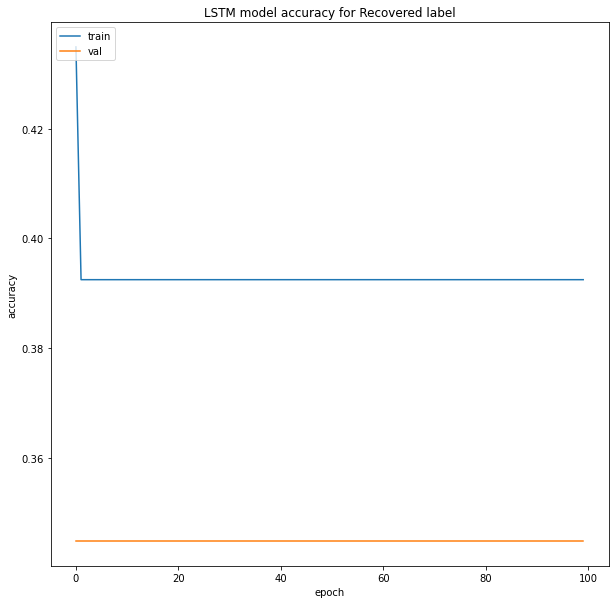

In [243]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Recovered label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy.png")

In [244]:
#Checking accuracy on test data
LSTM_Model.evaluate(X_test2, Y_test2, batch_size=20)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[nan, 0.33333334]

In [245]:
%%time
LSTM_Model.evaluate(X_test2, Y_test2, batch_size=20)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[nan, 0.33333334]

In [246]:
from sklearn.metrics import classification_report

y_pred = LSTM_Model.predict(X_test2, batch_size=20, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_labs = np.argmax(Y_test2, axis=1)

print(classification_report(y_labs, y_pred_bool))

2021-08-08 18:41:08.356537: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_208361' and '__inference_standard_lstm_208361_specialized_for_sequential_32_bidirectional_13_backward_lstm_13_StatefulPartitionedCall_at___inference_distributed_function_208707' both implement 'lstm_7a2810a4-5960-4fe6-8e50-f21f5c1d6012' but their signatures do not match.


204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Deaths Label - LSTM Implementation

In [250]:
X_train3 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train3 = df_covid_train[['Deaths']]
Y_train3 = Y_train3.astype(int)
Y_train_lstm_deaths = Y_train3.values

In [251]:
X_train_lstm_Deaths, Y_train_lstm_deaths = gen_sequences(X_train3, Y_train_lstm_deaths)
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X_train_lstm_Deaths, Y_train_lstm_deaths,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train4, X_val4, Y_train4, Y_val4 = train_test_split(X_train4, Y_train4,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train4.shape))
print('y_train:\t{}'.format(Y_train4.shape))
print('X_validation:\t{}'.format(X_val4.shape))
print('y_validation:\t{}'.format(Y_val4.shape))
print('X_test:\t{}'.format(X_test4.shape))
print('y_test:\t{}'.format(Y_test4.shape))

X_train:	(1037, 3, 21)
y_train:	(1037, 1)
X_validation:	(116, 3, 21)
y_validation:	(116, 1)
X_test:	(204, 3, 21)
y_test:	(204, 1)


In [252]:
in_shape = X_train4.shape[1:]
out_shape = Y_train4.shape[1]

LSTM_Model2 = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True, input_shape=in_shape )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model2.fit(X_train4, Y_train4, epochs=100, batch_size=256, validation_data=(X_val4,Y_val4))

# list all data in history
print(history.history.keys())

Train on 1037 samples, validate on 116 samples
Epoch 1/100


2021-08-08 18:44:27.866758: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_213819_214304' and '__inference___backward_standard_lstm_213819_214304_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_214967' both implement 'lstm_fce9dd30-cfbe-4f41-b386-653365d5c5c3' but their signatures do not match.


1024/1037 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.2725

2021-08-08 18:44:35.935574: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_215646_specialized_for_sequential_33_bidirectional_14_backward_lstm_14_StatefulPartitionedCall_at___inference_distributed_function_216052' and '__inference_cudnn_lstm_with_fallback_215759' both implement 'lstm_796a7a38-180f-4259-850d-96fd527acbb6' but their signatures do not match.


1037/1037 [==============================] - 14s 13ms/sample - loss: nan - accuracy: 0.2690 - val_loss: nan - val_accuracy: 0.1121
Epoch 2/100
1037/1037 [==============================] - 0s 444us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 3/100
1037/1037 [==============================] - 0s 440us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 4/100
1037/1037 [==============================] - 0s 405us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 5/100
1037/1037 [==============================] - 0s 423us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 6/100
1037/1037 [==============================] - 0s 423us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 7/100
1037/1037 [==============================] - 0s 431us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 8/100

1037/1037 [==============================] - 1s 495us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 59/100
1037/1037 [==============================] - 1s 512us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 60/100
1037/1037 [==============================] - 0s 437us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 61/100
1037/1037 [==============================] - 0s 463us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 62/100
1037/1037 [==============================] - 0s 429us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 63/100
1037/1037 [==============================] - 0s 478us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch 64/100
1037/1037 [==============================] - 0s 416us/sample - loss: nan - accuracy: 0.0974 - val_loss: nan - val_accuracy: 0.1121
Epoch

In [253]:
# Model summary
LSTM_Model2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio multiple                  28800     
_________________________________________________________________
dropout_78 (Dropout)         multiple                  0         
_________________________________________________________________
dense_115 (Dense)            multiple                  1010      
_________________________________________________________________
dropout_79 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_14 (Flatten)         multiple                  0         
_________________________________________________________________
dense_116 (Dense)            multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
_________________________________________________

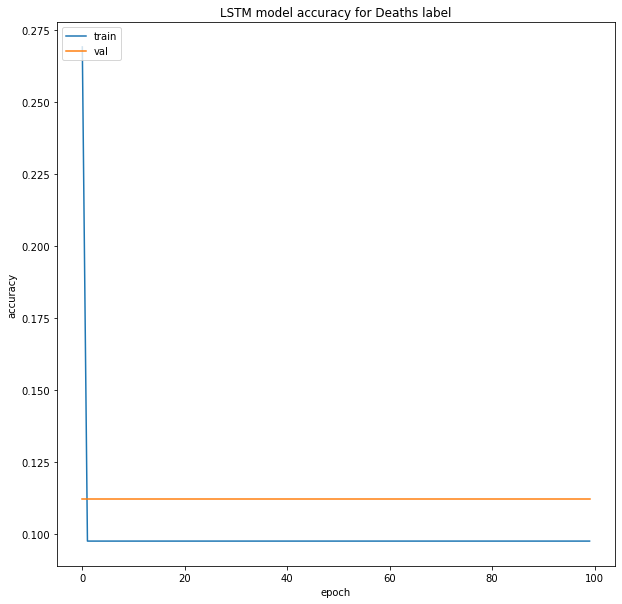

In [254]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Deaths label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy.png")

In [255]:
#Checking accuracy on test data
LSTM_Model2.evaluate(X_test4, Y_test4, batch_size=20)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[nan, 0.09803922]

In [256]:
%%time
LSTM_Model2.evaluate(X_test4, Y_test4, batch_size=20)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[nan, 0.09803922]

In [257]:
y_pred1 = LSTM_Model2.predict(X_test4, batch_size=20, verbose=1)
y_pred_bool1 = np.argmax(y_pred1, axis=1)
y_labs1 = np.argmax(Y_test4, axis=1)

print(classification_report(y_labs1, y_pred_bool1))

2021-08-08 18:45:47.383796: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_218953' and '__inference_standard_lstm_218953_specialized_for_sequential_33_bidirectional_14_forward_lstm_14_StatefulPartitionedCall_at___inference_distributed_function_219770' both implement 'lstm_3e1b8c82-6565-4950-8c41-c2835462175b' but their signatures do not match.


204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Confirmed Label - LSTM Implementation

In [258]:
X_train5 = df_covid_train.drop(['Recovered', 'Deaths', 'Confirmed'], axis =1).values
Y_train5 = df_covid_train[['Confirmed']]
Y_train5 = Y_train5.astype(int)
Y_train_lstm_confirmed = Y_train5.values
X_train_lstm_confirmed, Y_train_lstm_confirmed = gen_sequences(X_train5, Y_train_lstm_confirmed)
X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X_train_lstm_confirmed, Y_train_lstm_confirmed,
                                                     test_size=0.15, 
                                                     random_state=0,
                                                     shuffle=True)
X_train7, X_val7, Y_train7, Y_val7 = train_test_split(X_train6, Y_train6,
                                                     test_size=0.10, 
                                                     random_state=0,
                                                     shuffle=True)
#checking for the shape for new X_train, X_val, X_test, y_train, y_val, y_test
print('X_train:\t{}'.format(X_train7.shape))
print('y_train:\t{}'.format(Y_train7.shape))
print('X_validation:\t{}'.format(X_val7.shape))
print('y_validation:\t{}'.format(Y_val7.shape))
print('X_test:\t{}'.format(X_test6.shape))
print('y_test:\t{}'.format(Y_test6.shape))

X_train:	(1037, 3, 21)
y_train:	(1037, 1)
X_validation:	(116, 3, 21)
y_validation:	(116, 1)
X_test:	(204, 3, 21)
y_test:	(204, 1)


In [259]:
in_shape = X_train7.shape[1:]
out_shape = Y_train7.shape[1]

LSTM_Model3 = Sequential([
    tf.keras.layers.Bidirectional(LSTM(50, return_sequences = True )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

opt = optimizers.Adam(lr=0.001)
LSTM_Model3.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit the network
history = LSTM_Model3.fit(X_train7, Y_train7, epochs=50, batch_size=28, validation_data=(X_val7,Y_val7))

# list all data in history
print(history.history.keys())

Train on 1037 samples, validate on 116 samples
Epoch 1/50


2021-08-08 18:47:50.641847: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_224882_225367' and '__inference___backward_standard_lstm_224882_225367_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_226030' both implement 'lstm_e36849ce-d1a9-4502-ab2d-59c04161fa78' but their signatures do not match.


1008/1037 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0397

2021-08-08 18:47:59.114623: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_226808' and '__inference_standard_lstm_226808_specialized_for_sequential_34_bidirectional_15_backward_lstm_15_StatefulPartitionedCall_at___inference_distributed_function_227214' both implement 'lstm_4f44be57-9e02-4e10-9607-9e42f834ad19' but their signatures do not match.


1037/1037 [==============================] - 14s 14ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 2/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 3/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 4/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 5/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 6/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 7/50
1037/1037 [==============================] - 1s 1ms/sample - loss: nan - accuracy: 0.0395 - val_loss: nan - val_accuracy: 0.0345
Epoch 8/50
1037/1037 [=======

In [260]:
# Model summary
LSTM_Model3.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio multiple                  28800     
_________________________________________________________________
dropout_80 (Dropout)         multiple                  0         
_________________________________________________________________
dense_117 (Dense)            multiple                  1010      
_________________________________________________________________
dropout_81 (Dropout)         multiple                  0         
_________________________________________________________________
flatten_15 (Flatten)         multiple                  0         
_________________________________________________________________
dense_118 (Dense)            multiple                  62        
Total params: 29,872
Trainable params: 29,872
Non-trainable params: 0
_________________________________________________

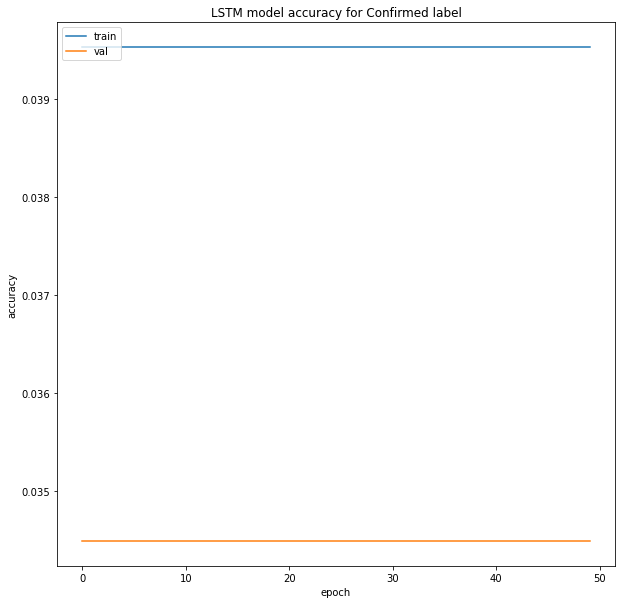

In [261]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM model accuracy for Confirmed label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_model_accuracy.png")

In [262]:
#Checking accuracy on test data
LSTM_Model3.evaluate(X_test6, Y_test6, batch_size=20)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[nan, 0.029411765]

In [263]:
y_pred2 = LSTM_Model3.predict(X_test6, batch_size=20, verbose=1)
y_pred_bool2 = np.argmax(y_pred2, axis=1)
y_labs2 = np.argmax(Y_test6, axis=1)

print(classification_report(y_labs2, y_pred_bool2))

2021-08-08 18:49:31.364485: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_234223_specialized_for_sequential_34_bidirectional_15_forward_lstm_15_StatefulPartitionedCall_at___inference_distributed_function_235040' and '__inference_standard_lstm_234223' both implement 'lstm_1eac1de4-22e5-4348-9ed8-8b15ccaf0260' but their signatures do not match.


204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Hyperparameter Selection - Recovered Label

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 50)                1100      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 50)              

Epoch 54/100
1037/1037 - 0s - loss: 0.3351 - accuracy: 0.8737 - val_loss: 0.2012 - val_accuracy: 0.9483
Epoch 55/100
1037/1037 - 0s - loss: 0.3276 - accuracy: 0.8660 - val_loss: 0.1986 - val_accuracy: 0.9569
Epoch 56/100
1037/1037 - 0s - loss: 0.3086 - accuracy: 0.8708 - val_loss: 0.1922 - val_accuracy: 0.9569
Epoch 57/100
1037/1037 - 0s - loss: 0.3215 - accuracy: 0.8621 - val_loss: 0.1869 - val_accuracy: 0.9483
Epoch 58/100
1037/1037 - 0s - loss: 0.2923 - accuracy: 0.8766 - val_loss: 0.1899 - val_accuracy: 0.9397
Epoch 59/100
1037/1037 - 0s - loss: 0.2989 - accuracy: 0.8756 - val_loss: 0.1880 - val_accuracy: 0.9397
Epoch 60/100
1037/1037 - 0s - loss: 0.2906 - accuracy: 0.8804 - val_loss: 0.1848 - val_accuracy: 0.9397
Epoch 61/100
1037/1037 - 0s - loss: 0.3063 - accuracy: 0.8775 - val_loss: 0.1776 - val_accuracy: 0.9310
Epoch 62/100
1037/1037 - 0s - loss: 0.2743 - accuracy: 0.8814 - val_loss: 0.1719 - val_accuracy: 0.9310
Epoch 63/100
1037/1037 - 0s - loss: 0.2844 - accuracy: 0.8737 - 

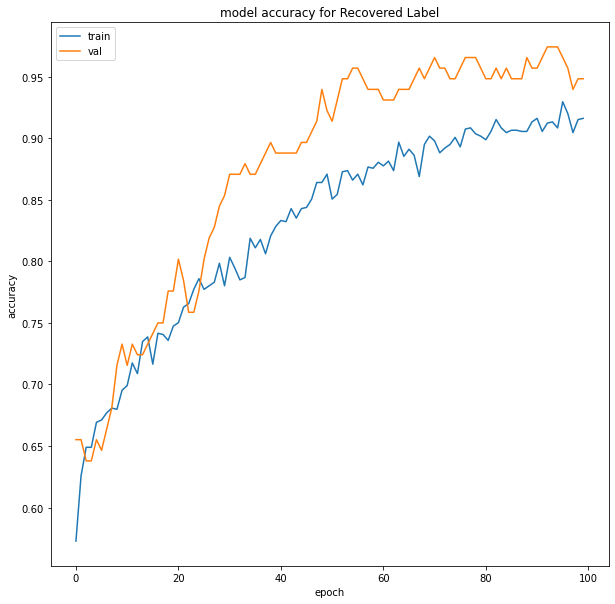

In [274]:
in_shape = X_train2.shape[1:]
out_shape = y_train_Recovered.shape[1]

model = Sequential([
    layers.Dense(50, input_shape=in_shape ),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(50),
    layers.LeakyReLU(),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = model.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, validation_data=(X_val2,y_val_Recovered), 
                    verbose=2, callbacks=[es])

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for Recovered Label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy_Recovered_LeakyReLu.png")

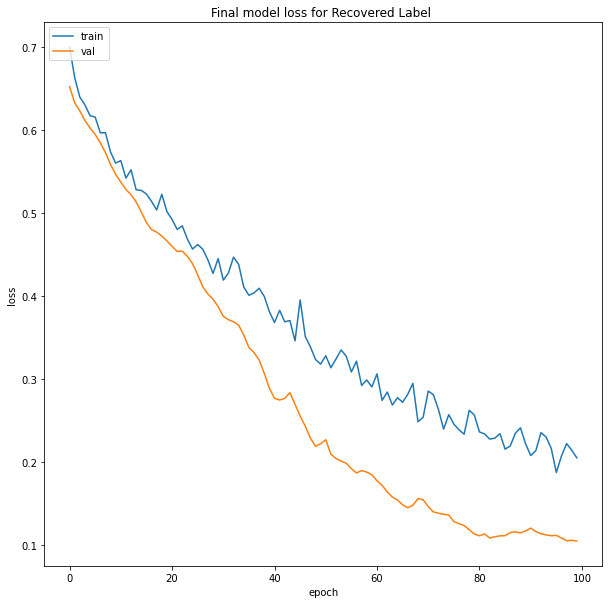

In [276]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Recovered Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Recovered_LeakyReLu.png")

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 50)                1100      
_________________________________________________________________
dropout_97 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_98 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_99 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_140 (Dense)            (None, 50)              

Epoch 61/500
1037/1037 - 0s - loss: 0.6933 - accuracy: 0.5921 - val_loss: 0.6972 - val_accuracy: 0.6293
Epoch 62/500
1037/1037 - 0s - loss: 0.6872 - accuracy: 0.5921 - val_loss: 0.6971 - val_accuracy: 0.6293
Epoch 63/500
1037/1037 - 0s - loss: 0.6863 - accuracy: 0.5844 - val_loss: 0.6972 - val_accuracy: 0.6293
Epoch 64/500
1037/1037 - 0s - loss: 0.6793 - accuracy: 0.5931 - val_loss: 0.6972 - val_accuracy: 0.6293
Epoch 65/500
1037/1037 - 0s - loss: 0.6947 - accuracy: 0.5834 - val_loss: 0.6972 - val_accuracy: 0.6293
Epoch 66/500
1037/1037 - 0s - loss: 0.6809 - accuracy: 0.6075 - val_loss: 0.6972 - val_accuracy: 0.6293
Epoch 67/500
1037/1037 - 0s - loss: 0.6939 - accuracy: 0.5950 - val_loss: 0.6971 - val_accuracy: 0.6293
Epoch 68/500
1037/1037 - 0s - loss: 0.6878 - accuracy: 0.5873 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 69/500
1037/1037 - 0s - loss: 0.6900 - accuracy: 0.5959 - val_loss: 0.6968 - val_accuracy: 0.6293
Epoch 70/500
1037/1037 - 0s - loss: 0.6903 - accuracy: 0.5940 - 

Epoch 140/500
1037/1037 - 0s - loss: 0.6857 - accuracy: 0.5834 - val_loss: 0.6973 - val_accuracy: 0.6293
Epoch 141/500
1037/1037 - 0s - loss: 0.6727 - accuracy: 0.5892 - val_loss: 0.6975 - val_accuracy: 0.6293
Epoch 142/500
1037/1037 - 0s - loss: 0.6817 - accuracy: 0.5998 - val_loss: 0.6977 - val_accuracy: 0.6293
Epoch 143/500
1037/1037 - 0s - loss: 0.6872 - accuracy: 0.5805 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 144/500
1037/1037 - 0s - loss: 0.6765 - accuracy: 0.6027 - val_loss: 0.6975 - val_accuracy: 0.6293
Epoch 145/500
1037/1037 - 0s - loss: 0.6854 - accuracy: 0.5998 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 146/500
1037/1037 - 0s - loss: 0.6723 - accuracy: 0.5988 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 147/500
1037/1037 - 0s - loss: 0.6859 - accuracy: 0.5911 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 148/500
1037/1037 - 0s - loss: 0.6846 - accuracy: 0.5873 - val_loss: 0.6977 - val_accuracy: 0.6293
Epoch 149/500
1037/1037 - 0s - loss: 0.6776 - accuracy:

1037/1037 - 0s - loss: 0.6764 - accuracy: 0.5892 - val_loss: 0.6971 - val_accuracy: 0.6293
Epoch 219/500
1037/1037 - 0s - loss: 0.6928 - accuracy: 0.5796 - val_loss: 0.6973 - val_accuracy: 0.6293
Epoch 220/500
1037/1037 - 0s - loss: 0.6760 - accuracy: 0.6104 - val_loss: 0.6971 - val_accuracy: 0.6293
Epoch 221/500
1037/1037 - 0s - loss: 0.6810 - accuracy: 0.5959 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 222/500
1037/1037 - 0s - loss: 0.6879 - accuracy: 0.5959 - val_loss: 0.6970 - val_accuracy: 0.6293
Epoch 223/500
1037/1037 - 0s - loss: 0.6855 - accuracy: 0.5882 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 224/500
1037/1037 - 0s - loss: 0.6748 - accuracy: 0.6075 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 225/500
1037/1037 - 0s - loss: 0.6874 - accuracy: 0.5969 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 226/500
1037/1037 - 0s - loss: 0.6819 - accuracy: 0.5921 - val_loss: 0.6968 - val_accuracy: 0.6293
Epoch 227/500
1037/1037 - 0s - loss: 0.6855 - accuracy: 0.5902 - val_

Epoch 297/500
1037/1037 - 0s - loss: 0.6734 - accuracy: 0.6017 - val_loss: 0.6967 - val_accuracy: 0.6293
Epoch 298/500
1037/1037 - 0s - loss: 0.6742 - accuracy: 0.6181 - val_loss: 0.6967 - val_accuracy: 0.6293
Epoch 299/500
1037/1037 - 0s - loss: 0.6887 - accuracy: 0.6046 - val_loss: 0.6967 - val_accuracy: 0.6293
Epoch 300/500
1037/1037 - 0s - loss: 0.6722 - accuracy: 0.6027 - val_loss: 0.6967 - val_accuracy: 0.6293
Epoch 301/500
1037/1037 - 0s - loss: 0.6633 - accuracy: 0.6075 - val_loss: 0.6968 - val_accuracy: 0.6293
Epoch 302/500
1037/1037 - 0s - loss: 0.6735 - accuracy: 0.6104 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 303/500
1037/1037 - 0s - loss: 0.6766 - accuracy: 0.6017 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 304/500
1037/1037 - 0s - loss: 0.6880 - accuracy: 0.5998 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 305/500
1037/1037 - 0s - loss: 0.6840 - accuracy: 0.6008 - val_loss: 0.6969 - val_accuracy: 0.6293
Epoch 306/500
1037/1037 - 0s - loss: 0.6784 - accuracy:

1037/1037 - 0s - loss: 0.6878 - accuracy: 0.5853 - val_loss: 0.6965 - val_accuracy: 0.6293
Epoch 376/500
1037/1037 - 0s - loss: 0.6782 - accuracy: 0.5959 - val_loss: 0.6965 - val_accuracy: 0.6293
Epoch 377/500
1037/1037 - 0s - loss: 0.6900 - accuracy: 0.5911 - val_loss: 0.6965 - val_accuracy: 0.6293
Epoch 378/500
1037/1037 - 0s - loss: 0.6716 - accuracy: 0.6046 - val_loss: 0.6967 - val_accuracy: 0.6293
Epoch 379/500
1037/1037 - 0s - loss: 0.6658 - accuracy: 0.6027 - val_loss: 0.6970 - val_accuracy: 0.6293
Epoch 380/500
1037/1037 - 0s - loss: 0.6735 - accuracy: 0.5921 - val_loss: 0.6970 - val_accuracy: 0.6293
Epoch 381/500
1037/1037 - 0s - loss: 0.6724 - accuracy: 0.6008 - val_loss: 0.6970 - val_accuracy: 0.6293
Epoch 382/500
1037/1037 - 0s - loss: 0.6759 - accuracy: 0.6017 - val_loss: 0.6971 - val_accuracy: 0.6293
Epoch 383/500
1037/1037 - 0s - loss: 0.6656 - accuracy: 0.6095 - val_loss: 0.6970 - val_accuracy: 0.6293
Epoch 384/500
1037/1037 - 0s - loss: 0.6759 - accuracy: 0.6008 - val_

Epoch 454/500
1037/1037 - 0s - loss: 0.6692 - accuracy: 0.6104 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 455/500
1037/1037 - 0s - loss: 0.6670 - accuracy: 0.6104 - val_loss: 0.6974 - val_accuracy: 0.6293
Epoch 456/500
1037/1037 - 0s - loss: 0.6704 - accuracy: 0.6104 - val_loss: 0.6974 - val_accuracy: 0.6293
Epoch 457/500
1037/1037 - 0s - loss: 0.6698 - accuracy: 0.6008 - val_loss: 0.6974 - val_accuracy: 0.6293
Epoch 458/500
1037/1037 - 0s - loss: 0.6724 - accuracy: 0.6104 - val_loss: 0.6975 - val_accuracy: 0.6293
Epoch 459/500
1037/1037 - 0s - loss: 0.6761 - accuracy: 0.6027 - val_loss: 0.6975 - val_accuracy: 0.6293
Epoch 460/500
1037/1037 - 0s - loss: 0.6735 - accuracy: 0.6017 - val_loss: 0.6976 - val_accuracy: 0.6293
Epoch 461/500
1037/1037 - 0s - loss: 0.6836 - accuracy: 0.6066 - val_loss: 0.6977 - val_accuracy: 0.6293
Epoch 462/500
1037/1037 - 0s - loss: 0.6646 - accuracy: 0.6008 - val_loss: 0.6977 - val_accuracy: 0.6293
Epoch 463/500
1037/1037 - 0s - loss: 0.6751 - accuracy:

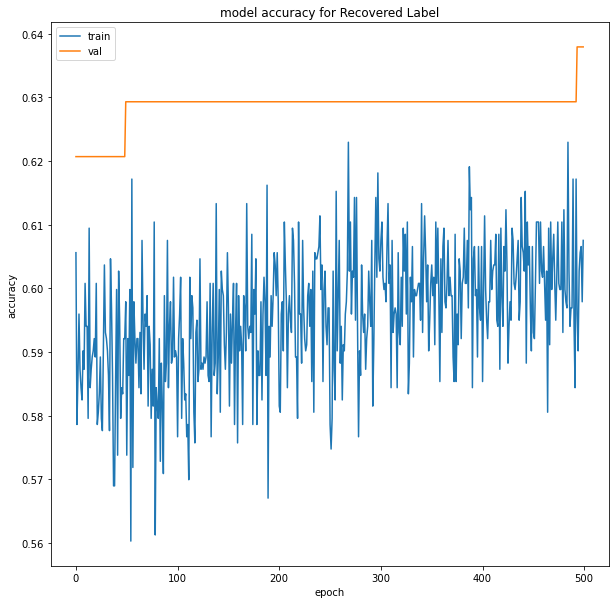

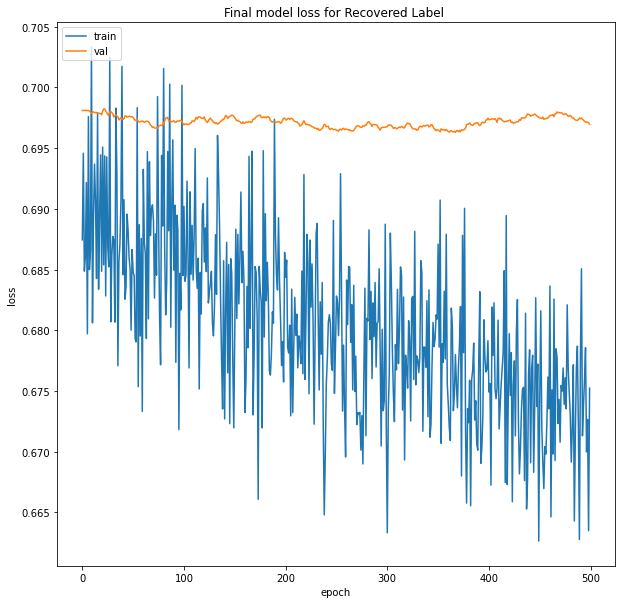

In [277]:
in_shape = X_train2.shape[1:]
out_shape = y_train_Recovered.shape[1]

model = Sequential([
    layers.Dense(50, activation='relu', input_shape=in_shape ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.SGD(lr=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(X_train2, Y_train2, epochs=500, batch_size=256, validation_data=(X_val2,y_val_Recovered), verbose=2)

# list all data in history
print(history.history.keys())

# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for Recovered Label')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy_Recovered_ReLu.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Recovered Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Recovered_ReLu.png")

### Final Custom Model - Recovered Label

In [293]:
input_shape = X_train2.shape[1]
out_shape = y_train_Recovered.shape[1]

final_model_Rec = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Rec.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Rec.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 50)                1100      
_________________________________________________________________
dropout_107 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_108 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_109 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 50)              

In [321]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Rec.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Recovered), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 0s 170us/sample - loss: 0.0399 - accuracy: 0.9846 - val_loss: 0.1071 - val_accuracy: 0.9741
Epoch 2/100
1037/1037 [==============================] - 0s 153us/sample - loss: 0.0440 - accuracy: 0.9875 - val_loss: 0.1057 - val_accuracy: 0.9741
Epoch 3/100
1037/1037 [==============================] - 0s 155us/sample - loss: 0.0433 - accuracy: 0.9855 - val_loss: 0.1380 - val_accuracy: 0.9655
Epoch 4/100
1037/1037 [==============================] - 0s 127us/sample - loss: 0.0501 - accuracy: 0.9855 - val_loss: 0.1357 - val_accuracy: 0.9655
Epoch 5/100
1037/1037 [==============================] - 0s 175us/sample - loss: 0.0526 - accuracy: 0.9836 - val_loss: 0.1196 - val_accuracy: 0.9569
Epoch 6/100
1037/1037 [==============================] - 0s 137us/sample - loss: 0.0415 - accuracy: 0.9875 - val_loss: 0.1007 - val_accuracy: 0.9569
Epoch 7/100
1037/1037 [==============================] - 0s

1037/1037 [==============================] - 0s 134us/sample - loss: 0.0538 - accuracy: 0.9836 - val_loss: 0.1007 - val_accuracy: 0.9741
Epoch 55/100
1037/1037 [==============================] - 0s 127us/sample - loss: 0.0483 - accuracy: 0.9846 - val_loss: 0.0908 - val_accuracy: 0.9741
Epoch 56/100
1037/1037 [==============================] - 0s 123us/sample - loss: 0.0488 - accuracy: 0.9865 - val_loss: 0.0833 - val_accuracy: 0.9741
Epoch 57/100
1037/1037 [==============================] - 0s 113us/sample - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.0800 - val_accuracy: 0.9741
Epoch 58/100
1037/1037 [==============================] - 0s 133us/sample - loss: 0.0453 - accuracy: 0.9836 - val_loss: 0.0807 - val_accuracy: 0.9741
Epoch 59/100
1037/1037 [==============================] - 0s 111us/sample - loss: 0.0522 - accuracy: 0.9769 - val_loss: 0.0888 - val_accuracy: 0.9741
Epoch 60/100
1037/1037 [==============================] - 0s 145us/sample - loss: 0.0432 - accuracy: 0.9875 - val

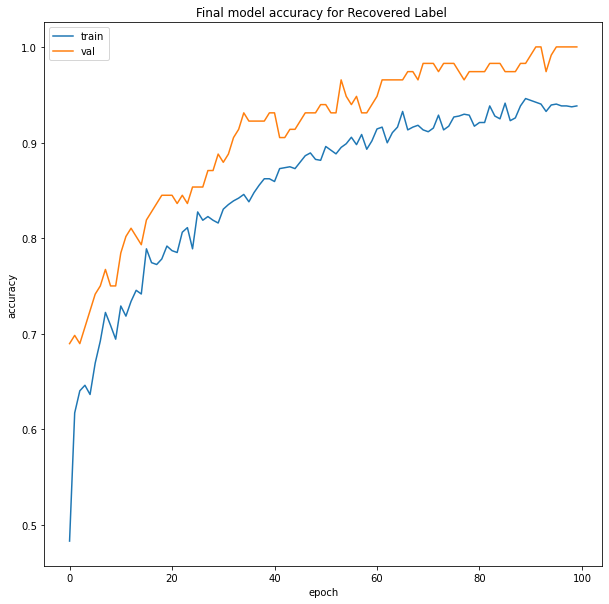

In [295]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Recovered Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Recovered.png")

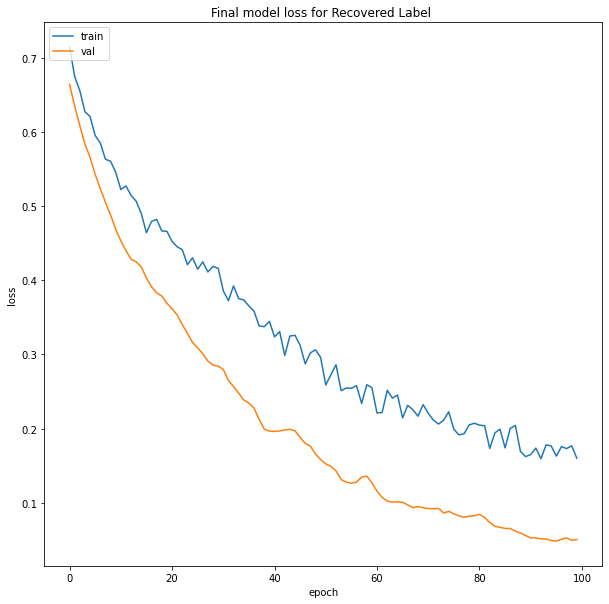

In [296]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Recovered Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Recovered.png")

In [297]:
%%time
results = final_model_Rec.evaluate(X_test1, y_test_Recovered, batch_size=128)
print("test loss, test acc:", results)

204/204 [==============================] - 0s 150us/sample - loss: 0.1189 - accuracy: 0.9657
test loss, test acc: [0.11893161809911915, 0.96568626]
CPU times: user 26.8 ms, sys: 11.8 ms, total: 38.6 ms
Wall time: 40.6 ms


### Final Custom Model - Deaths Label

In [323]:
input_shape = X_train2.shape[1]
out_shape = y_train_Deaths.shape[1]

final_model_Deaths = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Deaths.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Deaths.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 50)                1100      
_________________________________________________________________
dropout_112 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_113 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_157 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_114 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 50)              

In [324]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Deaths.fit(X_train2, y_train_Deaths, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Deaths), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 3s 3ms/sample - loss: 0.6261 - accuracy: 0.7049 - val_loss: 0.4871 - val_accuracy: 0.9397
Epoch 2/100
1037/1037 [==============================] - 0s 144us/sample - loss: 0.4835 - accuracy: 0.8901 - val_loss: 0.3795 - val_accuracy: 0.9397
Epoch 3/100
1037/1037 [==============================] - 0s 130us/sample - loss: 0.4180 - accuracy: 0.8987 - val_loss: 0.3227 - val_accuracy: 0.9397
Epoch 4/100
1037/1037 [==============================] - 0s 126us/sample - loss: 0.4249 - accuracy: 0.8987 - val_loss: 0.2951 - val_accuracy: 0.9397
Epoch 5/100
1037/1037 [==============================] - 0s 135us/sample - loss: 0.3910 - accuracy: 0.8987 - val_loss: 0.2775 - val_accuracy: 0.9397
Epoch 6/100
1037/1037 [==============================] - 0s 155us/sample - loss: 0.3571 - accuracy: 0.8987 - val_loss: 0.2659 - val_accuracy: 0.9397
Epoch 7/100
1037/1037 [==============================] - 0s 1

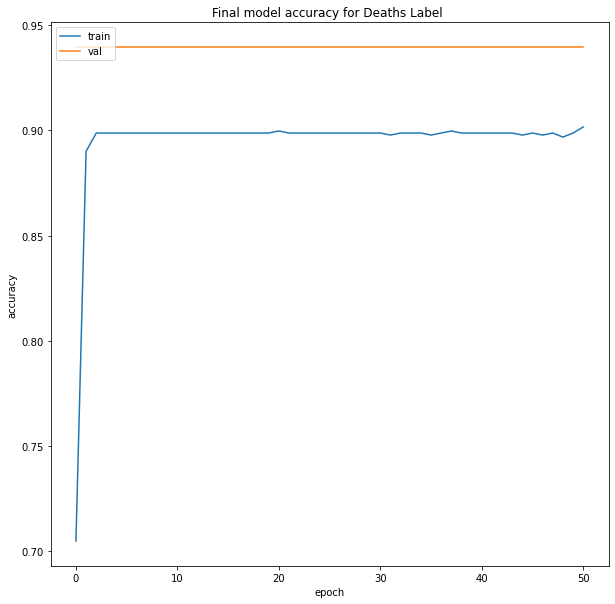

In [325]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Deaths Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Deaths.png")

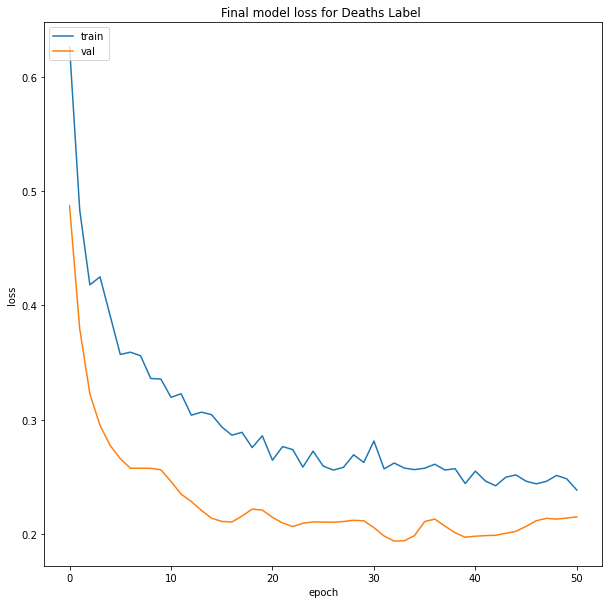

In [326]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Deaths Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Deaths.png")

In [327]:
%%time
results = final_model_Deaths.evaluate(X_test1, y_test_Deaths, batch_size=128)
print("test loss, test acc:", results)

204/204 [==============================] - 0s 149us/sample - loss: 0.3014 - accuracy: 0.8922
test loss, test acc: [0.3013796730368745, 0.89215684]
CPU times: user 23.2 ms, sys: 5.45 ms, total: 28.6 ms
Wall time: 53.2 ms


### Final Custom Model - Confirmed Label

In [328]:
input_shape = X_train2.shape[1]
out_shape = y_train_Confirmed.shape[1]

final_model_Confirmed = Sequential([
    layers.Dense(50, activation='relu', input_shape=(input_shape,) ),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

opt = optimizers.Adam(lr=0.001)

final_model_Confirmed.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(final_model_Confirmed.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_161 (Dense)            (None, 50)                1100      
_________________________________________________________________
dropout_117 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_118 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_163 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_119 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 50)              

In [329]:
%%time
# fit the network
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=50)
history = final_model_Confirmed.fit(X_train2, y_train_Confirmed, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Confirmed), verbose=1, callbacks=[es])

# list all data in history
print(history.history.keys())

Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 3s 3ms/sample - loss: 0.5404 - accuracy: 0.8544 - val_loss: 0.3547 - val_accuracy: 0.9655
Epoch 2/100
1037/1037 [==============================] - 0s 148us/sample - loss: 0.3262 - accuracy: 0.9595 - val_loss: 0.2075 - val_accuracy: 0.9655
Epoch 3/100
1037/1037 [==============================] - 0s 127us/sample - loss: 0.2300 - accuracy: 0.9614 - val_loss: 0.1526 - val_accuracy: 0.9655
Epoch 4/100
1037/1037 [==============================] - 0s 145us/sample - loss: 0.1985 - accuracy: 0.9614 - val_loss: 0.1440 - val_accuracy: 0.9655
Epoch 5/100
1037/1037 [==============================] - 0s 133us/sample - loss: 0.1982 - accuracy: 0.9614 - val_loss: 0.1404 - val_accuracy: 0.9655
Epoch 6/100
1037/1037 [==============================] - 0s 141us/sample - loss: 0.2076 - accuracy: 0.9614 - val_loss: 0.1283 - val_accuracy: 0.9655
Epoch 7/100
1037/1037 [==============================] - 0s 1

1037/1037 [==============================] - 0s 143us/sample - loss: 0.0483 - accuracy: 0.9769 - val_loss: 0.0577 - val_accuracy: 0.9828
Epoch 55/100
1037/1037 [==============================] - 0s 150us/sample - loss: 0.0508 - accuracy: 0.9778 - val_loss: 0.0568 - val_accuracy: 0.9828
Epoch 56/100
1037/1037 [==============================] - 0s 133us/sample - loss: 0.0546 - accuracy: 0.9797 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 57/100
1037/1037 [==============================] - 0s 143us/sample - loss: 0.0441 - accuracy: 0.9807 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 58/100
1037/1037 [==============================] - 0s 142us/sample - loss: 0.0435 - accuracy: 0.9826 - val_loss: 0.0544 - val_accuracy: 0.9828
Epoch 59/100
1037/1037 [==============================] - 0s 149us/sample - loss: 0.0467 - accuracy: 0.9778 - val_loss: 0.0554 - val_accuracy: 0.9828
Epoch 60/100
1037/1037 [==============================] - 0s 141us/sample - loss: 0.0567 - accuracy: 0.9807 - val

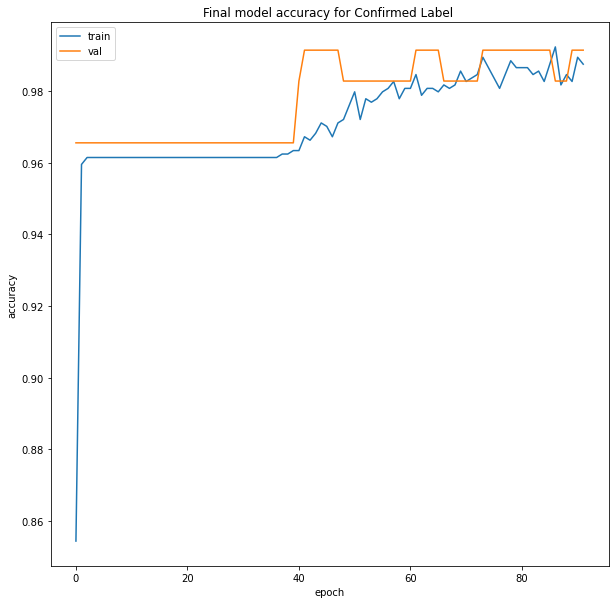

In [330]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final model accuracy for Confirmed Label ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_accuracy_Confirmed.png")

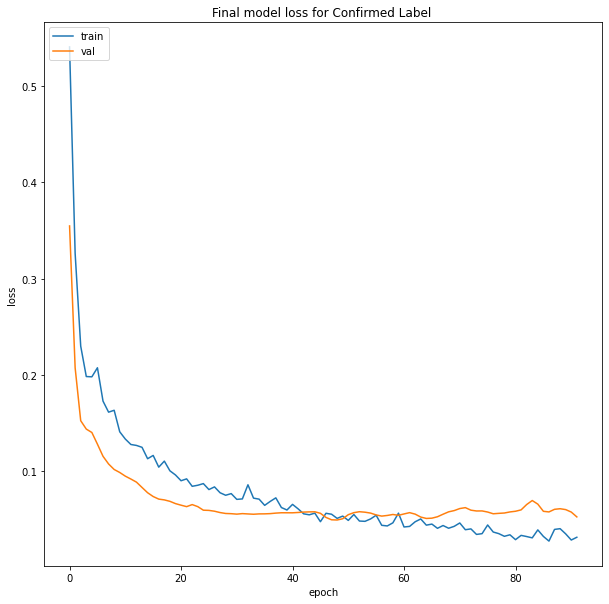

In [331]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final model loss for Confirmed Label ')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("Final_model_loss_Confirmed.png")

In [332]:
%%time
results = final_model_Confirmed.evaluate(X_test1, y_test_Confirmed, batch_size=128)
print("test loss, test acc:", results)

204/204 [==============================] - 0s 73us/sample - loss: 0.0245 - accuracy: 0.9902
test loss, test acc: [0.02451551168718759, 0.99019605]
CPU times: user 23.3 ms, sys: 7.06 ms, total: 30.3 ms
Wall time: 23.4 ms


### [CM5] Kaggle Submission

In [300]:
#loading test dataset for Kaggle submission
covid_test = pd.read_csv("dkmacovid_kaggletest_features.csv")

In [301]:
#Type-casting the population and population density data into float data type
covid_test[['Resident Population 2020 Census', 'Population Density 2020 Census']] = covid_test[['Resident Population 2020 Census', 
                                                                                      'Population Density 2020 Census']].replace({",":""},
                                                                                       regex=True).apply(pd.to_numeric,1)

In [302]:
# Getting the relative difference values for specific quantitative attributes with respect to the state as done 
#for the traning dataset

covid_test = ReativeFeature(covid_test, 'Active')
covid_test = ReativeFeature(covid_test, 'Case_Fatality_Ratio')
covid_test = ReativeFeature(covid_test, 'Incident_Rate')
covid_test = ReativeFeature(covid_test, 'Total_Test_Results')
covid_test = ReativeFeature(covid_test, 'Testing_Rate')

covid_test

,Id,Day,State ID,State,Lat,Long_,Active,Incident_Rate,Total_Test_Results,Case_Fatality_Ratio,Testing_Rate,Resident Population 2020 Census,Population Density 2020 Census,Density Rank 2020 Census,SexRatio,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Total_Test_Results,Relative_Testing_Rate
0,0,2,14,Illinois,40.3495,-88.9861,957138,7697.015291,13436652,1.867428,106035.68340,12812508.0,230.8,14,97,1.0,1.000000,1.000000,1.0,1.00000
1,5,3,14,Illinois,40.3495,-88.9861,961499,7732.282519,13482117,1.869933,106394.47160,12812508.0,230.8,14,97,4361.0,0.002505,35.267228,45465.0,358.78820
2,10,4,14,Illinois,40.3495,-88.9861,966468,7772.205747,13530371,1.869466,106775.26930,12812508.0,230.8,14,97,4969.0,-0.000467,39.923228,48254.0,380.79770
3,15,5,14,Illinois,40.3495,-88.9861,973157,7826.175891,13617454,1.871700,107462.48700,12812508.0,230.8,14,97,6689.0,0.002233,53.970144,87083.0,687.21770
4,20,6,14,Illinois,40.3495,-88.9861,980553,7885.906848,13698428,1.874835,108101.49540,12812508.0,230.8,14,97,7396.0,0.003135,59.730957,80974.0,639.00840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,129,27,48,Washington,47.4009,-121.4905,301078,4009.104264,4446844,1.379349,58396.67084,7705281.0,115.9,24,100,1763.0,0.006285,23.729814,22614.0,296.97069
146,134,28,48,Washington,47.4009,-121.4905,303566,4042.197310,4470215,1.378452,58703.58257,7705281.0,115.9,24,100,2488.0,-0.000897,33.093046,23371.0,306.91173
147,139,29,48,Washington,47.4009,-121.4905,305516,4068.356574,4495463,1.383146,59035.14337,7705281.0,115.9,24,100,1950.0,0.004694,26.159264,25248.0,331.56080
148,144,30,48,Washington,47.4009,-121.4905,307312,4091.941935,4524221,1.375174,59412.79805,7705281.0,115.9,24,100,1796.0,-0.007972,23.585361,28758.0,377.65468


In [303]:
#dropping certain columns as done in the training dataset
covid_test_update = covid_test[covid_test.columns.difference(['Lat', 'Long_', 'Id', 'State'])]
covid_test_update

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,957138,1.867428,2,14,7697.015291,230.8,1.0,1.000000,1.000000,1.00000,1.0,12812508.0,97,14,106035.68340,13436652
1,961499,1.869933,3,14,7732.282519,230.8,4361.0,0.002505,35.267228,358.78820,45465.0,12812508.0,97,14,106394.47160,13482117
2,966468,1.869466,4,14,7772.205747,230.8,4969.0,-0.000467,39.923228,380.79770,48254.0,12812508.0,97,14,106775.26930,13530371
3,973157,1.871700,5,14,7826.175891,230.8,6689.0,0.002233,53.970144,687.21770,87083.0,12812508.0,97,14,107462.48700,13617454
4,980553,1.874835,6,14,7885.906848,230.8,7396.0,0.003135,59.730957,639.00840,80974.0,12812508.0,97,14,108101.49540,13698428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,301078,1.379349,27,24,4009.104264,115.9,1763.0,0.006285,23.729814,296.97069,22614.0,7705281.0,100,48,58396.67084,4446844
146,303566,1.378452,28,24,4042.197310,115.9,2488.0,-0.000897,33.093046,306.91173,23371.0,7705281.0,100,48,58703.58257,4470215
147,305516,1.383146,29,24,4068.356574,115.9,1950.0,0.004694,26.159264,331.56080,25248.0,7705281.0,100,48,59035.14337,4495463
148,307312,1.375174,30,24,4091.941935,115.9,1796.0,-0.007972,23.585361,377.65468,28758.0,7705281.0,100,48,59412.79805,4524221


In [304]:
scaler = preprocessing.StandardScaler()
scaled_covid_test=covid_test_update.copy()
scaled_covid_test=pd.DataFrame(scaler.fit_transform(scaled_covid_test), columns=scaled_covid_test.columns)
scaled_covid_test

,Active,Case_Fatality_Ratio,Day,Density Rank 2020 Census,Incident_Rate,Population Density 2020 Census,Relative_Active,Relative_Case_Fatality_Ratio,Relative_Incident_Rate,Relative_Testing_Rate,Relative_Total_Test_Results,Resident Population 2020 Census,SexRatio,State ID,Testing_Rate,Total_Test_Results
0,1.630365,1.718143,-1.675247,-1.392419,-0.034670,1.605706,-0.410182,5.375847,-1.643657,-1.436507,-1.044578,0.094176,-0.559017,-1.283315,1.252685,0.874530
1,1.642290,1.729474,-1.559712,-1.392419,-0.019131,1.605706,0.717905,-0.182509,-0.409462,-0.020155,-0.095284,0.094176,-0.559017,-1.283315,1.265333,0.882366
2,1.655878,1.727361,-1.444178,-1.392419,-0.001540,1.605706,0.875217,-0.199070,-0.241768,0.066973,-0.037049,0.094176,-0.559017,-1.283315,1.278757,0.890682
3,1.674170,1.737463,-1.328644,-1.392419,0.022241,1.605706,1.320242,-0.184024,0.264156,1.279977,0.773706,0.094176,-0.559017,-1.283315,1.302983,0.905691
4,1.694395,1.751645,-1.213110,-1.392419,0.048560,1.605706,1.503168,-0.178997,0.471642,1.089134,0.646149,0.094176,-0.559017,-1.283315,1.325509,0.919647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.163676,-0.489574,1.213110,-0.103142,-1.659654,-0.352846,0.045710,-0.161443,-0.825003,-0.264868,-0.572416,-0.465357,1.118034,1.013144,-0.426668,-0.674859
146,-0.156872,-0.493630,1.328644,-0.103142,-1.645072,-0.352846,0.233293,-0.201463,-0.487769,-0.225515,-0.556610,-0.465357,1.118034,1.013144,-0.415848,-0.670832
147,-0.151540,-0.472399,1.444178,-0.103142,-1.633546,-0.352846,0.094094,-0.170313,-0.737502,-0.127938,-0.517417,-0.465357,1.118034,1.013144,-0.404160,-0.666480
148,-0.146628,-0.508459,1.559712,-0.103142,-1.623153,-0.352846,0.054248,-0.240892,-0.830205,0.054531,-0.444128,-0.465357,1.118034,1.013144,-0.390847,-0.661524


In [305]:
covid_test_pca = pca_covid_data.transform(scaled_covid_test)
print(covid_test_pca.shape)

(150, 10)


In [306]:
#Making the hybrid test dataset by using covid_test_update along with first 5 PCA components.

x = covid_test_pca[:, 0].tolist()
scaled_covid_test.loc[:, 'PCA1'] = x
x = covid_test_pca[:, 1].tolist()
scaled_covid_test.loc[:, 'PCA2'] = x
x = covid_test_pca[:, 2].tolist()
scaled_covid_test.loc[:, 'PCA3'] = x
x = covid_test_pca[:, 3].tolist()
scaled_covid_test.loc[:, 'PCA4'] = x
x = covid_test_pca[:, 4].tolist()
scaled_covid_test.loc[:, 'PCA5'] = x

In [308]:
recovered_labels = y_train_Recovered
confirmed_labels = y_train_Confirmed
deaths_labels = y_train_Deaths
recovered_labels

,Recovered
75,1
221,1
870,1
285,0
1148,1
...,...
1083,1
962,1
1102,1
368,0


### For "Recovered" class

In [309]:
scaled_covid_test.shape

(150, 21)

In [336]:
final_model_Rec.fit(X_train2, y_train_Recovered, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Recovered), verbose=1, callbacks=[es])
recovered_test_predict = final_model_Rec.predict(scaled_covid_test, batch_size=20, verbose=1)
recovered_test_predict = pd.DataFrame(recovered_test_predict)[0]
recovered_test_predict = recovered_test_predict.round(0).astype(int)


Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 1s 572us/sample - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.1274 - val_accuracy: 0.9741
Epoch 2/100
1037/1037 [==============================] - 1s 585us/sample - loss: 0.0336 - accuracy: 0.9884 - val_loss: 0.1318 - val_accuracy: 0.9741
Epoch 3/100
1037/1037 [==============================] - 0s 425us/sample - loss: 0.0406 - accuracy: 0.9884 - val_loss: 0.1990 - val_accuracy: 0.9655
Epoch 4/100
1037/1037 [==============================] - 0s 173us/sample - loss: 0.0542 - accuracy: 0.9855 - val_loss: 0.2045 - val_accuracy: 0.9655
Epoch 5/100
1037/1037 [==============================] - 0s 139us/sample - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.1840 - val_accuracy: 0.9655
Epoch 6/100
1037/1037 [==============================] - 0s 123us/sample - loss: 0.0456 - accuracy: 0.9836 - val_loss: 0.1601 - val_accuracy: 0.9655
Epoch 7/100
1037/1037 [==============================] - 0s

In [351]:
default_model_Recovered.fit(X_train2,y_train_Recovered, epochs = 100,
                            validation_data=(X_val2,y_val_Recovered), 
                            verbose=0, batch_size=50)
recovered_predict_test = default_model_Recovered.predict(scaled_covid_test, batch_size=20, verbose=1)
recovered_predict_test = pd.DataFrame(recovered_test_predict)[0]
recovered_predict_test

150/150 [==============================] - 0s 1ms/sample


0      0
1      0
2      0
3      1
4      1
      ..
145    1
146    1
147    1
148    1
149    1
Name: 0, Length: 150, dtype: int64

In [337]:
recovered_test_predict

0      0
1      0
2      0
3      1
4      1
      ..
145    1
146    1
147    1
148    1
149    1
Name: 0, Length: 150, dtype: int64

### For "Confirmed" class

In [347]:
final_model_Confirmed.fit(X_train2, y_train_Confirmed, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Confirmed), verbose=1, callbacks=[es])
confirmed_test_predict = final_model_Confirmed.predict(scaled_covid_test, batch_size=20, verbose=1)
confirmed_test_predict = pd.DataFrame(confirmed_test_predict)[0]
confirmed_test_predict

Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 0s 141us/sample - loss: 0.0174 - accuracy: 0.9884 - val_loss: 0.0858 - val_accuracy: 0.9914
Epoch 2/100
1037/1037 [==============================] - 0s 128us/sample - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0847 - val_accuracy: 0.9914
Epoch 3/100
1037/1037 [==============================] - 0s 155us/sample - loss: 0.0177 - accuracy: 0.9923 - val_loss: 0.0856 - val_accuracy: 0.9914
Epoch 4/100
1037/1037 [==============================] - 0s 170us/sample - loss: 0.0225 - accuracy: 0.9913 - val_loss: 0.0874 - val_accuracy: 0.9914
Epoch 5/100
1037/1037 [==============================] - 0s 139us/sample - loss: 0.0121 - accuracy: 0.9952 - val_loss: 0.0911 - val_accuracy: 0.9914
Epoch 6/100
1037/1037 [==============================] - 0s 161us/sample - loss: 0.0186 - accuracy: 0.9923 - val_loss: 0.0946 - val_accuracy: 0.9914
Epoch 7/100
1037/1037 [==============================] - 0s

0      8.341863e-11
1      7.508021e-23
2      5.362005e-27
3      0.000000e+00
4      0.000000e+00
           ...     
145    3.565955e-13
146    6.222651e-18
147    1.241230e-14
148    4.751300e-15
149    1.907022e-03
Name: 0, Length: 150, dtype: float32

In [348]:
confirmed_test_predict = confirmed_test_predict.round(0).astype(int)
confirmed_test_predict

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: 0, Length: 150, dtype: int64

In [354]:
default_model_Confirmed.fit(X_train2,y_train_Confirmed, epochs = 100,
                            validation_data=(X_val2,y_val_Confirmed), 
                            verbose=0, batch_size=50)
confirmed_predict_test = default_model_Confirmed.predict(scaled_covid_test, batch_size=20, verbose=1)
confirmed_predict_test = pd.DataFrame(confirmed_test_predict)[0]

150/150 [==============================] - 0s 103us/sample


In [355]:
confirmed_predict_test

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    0
Name: 0, Length: 150, dtype: int64

### For "Deaths" class

In [343]:
final_model_Deaths.fit(X_train2, y_train_Deaths, epochs=100, batch_size=256, 
                              validation_data=(X_val2,y_val_Deaths), verbose=1, callbacks=[es])
deaths_test_predict = final_model_Deaths.predict(scaled_covid_test, batch_size=20, verbose=1)
deaths_test_predict = pd.DataFrame(deaths_test_predict)[0]

Train on 1037 samples, validate on 116 samples
Epoch 1/100
1037/1037 [==============================] - 0s 106us/sample - loss: 0.1811 - accuracy: 0.9132 - val_loss: 0.1660 - val_accuracy: 0.9483
Epoch 2/100
1037/1037 [==============================] - 0s 163us/sample - loss: 0.1748 - accuracy: 0.9209 - val_loss: 0.1701 - val_accuracy: 0.9483
Epoch 3/100
1037/1037 [==============================] - 0s 145us/sample - loss: 0.1810 - accuracy: 0.9257 - val_loss: 0.1751 - val_accuracy: 0.9224
Epoch 4/100
1037/1037 [==============================] - 0s 151us/sample - loss: 0.1907 - accuracy: 0.9161 - val_loss: 0.1781 - val_accuracy: 0.9052
Epoch 5/100
1037/1037 [==============================] - 0s 148us/sample - loss: 0.1835 - accuracy: 0.9257 - val_loss: 0.1788 - val_accuracy: 0.9138
Epoch 6/100
1037/1037 [==============================] - 0s 158us/sample - loss: 0.1917 - accuracy: 0.9190 - val_loss: 0.1803 - val_accuracy: 0.9052
Epoch 7/100
1037/1037 [==============================] - 0s

0      0.166869
1      0.021657
2      0.017006
3      0.000985
4      0.001898
         ...   
145    0.419981
146    0.334497
147    0.375573
148    0.417714
149    0.552971
Name: 0, Length: 150, dtype: float32

In [346]:
deaths_test_predict = deaths_test_predict.round(0).astype(int)
deaths_test_predict

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    1
Name: 0, Length: 150, dtype: int64

In [356]:
default_model_Deaths.fit(X_train2,y_train_Deaths, epochs = 100,
                            validation_data=(X_val2,y_val_Deaths), 
                            verbose=0, batch_size=50)
deaths_predict_test = default_model_Deaths.predict(scaled_covid_test, batch_size=20, verbose=1)
deaths_predict_test = pd.DataFrame(deaths_test_predict)[0]

150/150 [==============================] - 0s 1ms/sample


In [357]:
deaths_predict_test

0      0
1      0
2      0
3      0
4      0
      ..
145    0
146    0
147    0
148    0
149    1
Name: 0, Length: 150, dtype: int64

In [349]:
kaggle_output = pd.DataFrame({
    'Id': covid_test.Id,
    'Confirmed': confirmed_test_predict,
    'Deaths': deaths_test_predict,
    'Recovered': recovered_test_predict
})

In [358]:
kaggle_output_default_model = pd.DataFrame({
    'Id': covid_test.Id,
    'Confirmed': confirmed_predict_test,
    'Deaths': deaths_predict_test,
    'Recovered': recovered_predict_test
})

In [350]:
kaggle_output.to_csv("dkma_output_submit_DNN.csv", index=False)

In [359]:
kaggle_output_default_model.to_csv("dkma_output_submit_DefaultDNN.csv", index=False)